# Proyecto Integrador 

El siguiente código responde a un análisis descriptivo y predictivo de datasets de gestión de la red de colegios **Cosmo**. Su finalidad es encontrar relaciones entre datos sociodemográficos y datos académicos. En concreto, con el código se rastrea la hipótesis de que las condiciones sociodemográficas adversas impactan directamente el rendimiento académico de los estudiantes.

El proyecto integrador está en el marco de los requisitos de la maestría en ciencias de los datos de la universidad **EAFIT**. 

---

Integrantes del Proyecto: 

*  Juan Camilo Osorio González
*  Camila Diaz Zuluaga
*  David Santiago Osorio Aristizábal
*  Juan Diego Atehortúa Cataño


## Creación de ambiente


In [ ]:
## Convenciones de Reproducibilidad 

# Los datasets nativos están nombrados:

## Dataset Académico ----> 'linea_base_2023_1_anonimizada.xlsx'
## Dataset Sociodemográfico ----> 'estudiantes_anonimizados.xlsx'


In [ ]:

# Contexto Google Colab

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Dependencias

import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.2f' % x)
import matplotlib.pyplot as plt 
import missingno as msno
import seaborn as sns

from sklearn import preprocessing
from numpy.linalg import inv
from scipy.spatial import distance

## Lectura de Datos

In [ ]:
# DataFrame Sociodemográfico Estudiantes

## Sin vinculación a Colab:
# estudiantes = pd.pd.read_excel('/content/estudiantes_anonimizados.xlsx')

estudiantes = pd.read_excel('/content/gdrive/MyDrive/Colab Notebooks/PROYECTO INTEGRADOR/data/estudiantes_anonimizados.xlsx')

In [ ]:
# DataFrame Linea Base Académica

## Sin vinculación a Colab:
# linea_base = pd.read_excel('/content/linea_base_2023_1_anonimizada.xlsx')

linea_base = pd.read_excel('/content/gdrive/MyDrive/Colab Notebooks/PROYECTO INTEGRADOR/data/linea_base_2023_1_anonimizada.xlsx')

In [ ]:
# Evaluación de Compatibilidad de DataFrames

# Instancia de contador
contador = 0

# Creación de listas de estudiantes únicos de la línea base y de los estudiantes
lista_linea_base = list(linea_base['estudiante'].unique())
lista_estudiantes = list(estudiantes['id_estudiante'].unique())

# Iteración sobre cada estudiante de la lista de la línea base
for est in lista_linea_base:
    # Comprobación de si el estudiante está presente en la lista de estudiantes
    if est in lista_estudiantes:
        # Incremento del contador si el estudiante está presente en ambas listas
        contador += 1


In [ ]:
print(f'Hay {contador} registros que están en ambos datasets.')

Hay 1165 registros que están en ambos datasets.


## Metodo 1: Depuración de variables por métodos heurísticos

## Preprocesamiento 

**Nota**: En esta sección se hace una limpieza de los datasets. Especificamente, se seleccionan las variables tanto académicas como sociodemográficas con mayor información y calidad de datos. Los criterios de selección en este punto no son estadísticos, sino prácticos o heurísticos.

>En el dataset `linea_base` se seleccionan las cuatro asignaturas generales.

>En el dataset `estudiantes` se seleccionan las variables de mayor calidad.  

In [1985]:
# Selección de Variables de Resultados en DataFrame `linea_base`

resultadosPruebas = linea_base[['estudiante','Grado','Ciencias Naturales',
       'Competencias Ciudadanas', 'Lenguaje', 'Matematicas']]

In [1986]:
# Selección de Variables Sociodemográficas del DataFrame `estudiantes`

socioDemo = estudiantes[['id_estudiante', 'Género', 'Fecha de nacimiento','Fecha de nacimiento acudiente','Sede', 'Nivel académico acudiente', 'Nivel académico responsable de pago',
             'Nivel académico del familiar','Tipo de empleado acudiente', 'Tipo de empleado responsable de pago', 'Tipo de empleado del familiar', 
             '¿El aspirante es población víctima de conflicto?', 'Estrato','¿Cuenta con servicio de agua?', '¿Cuenta con servicio de alcantarillado?', '¿Cuenta con servicio de gas?',
             '¿Cuenta con servicio de internet?', '¿Cuenta con servicio de energía?', '¿Cuál es el tipo de familia?', '¿Con cuántas personas vive?', 'Madre cabeza de familia',
             'Realiza algún tipo de trabajo remunerado o no remunerado', '¿Tuvo educación preescolar?']]

### Rastreo de datos nulos

**Nota**: Esta sección se implementa para rastrear los datos nulos en cada uno de los DataFrames. Se crea una columna nueva en ambos llamada `Conteo_NaNs`. El propósito de ello es discriminar las filas de mayor calidad. 

In [1987]:
# Creación Col 'Conteo_NaNs' en DataFrame Sociodemográfico

socioDemo.loc[:, ('Conteo_NaNs')] = ""

<ipython-input-1987-8d1df312e80e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  socioDemo.loc[:, ('Conteo_NaNs')] = ""


In [1988]:
# Conteo de NaNs por fila

# Obtener los IDs únicos de los estudiantes en una lista
ids_unicos = socioDemo['id_estudiante'].unique().tolist()

# Iterar sobre cada ID único
for i in ids_unicos:
    # Obtener los índices de las filas correspondientes a ese ID
    lista_indices_filas = socioDemo[socioDemo['id_estudiante'] == i].index.tolist()
    
    # Iterar sobre cada índice de fila
    for idx in lista_indices_filas:
        # Calcular la suma de valores nulos en la fila actual
        suma_nulos = socioDemo.iloc[idx, :].isnull().sum()
        
        # Asignar la suma de nulos a la columna 'conteo_nulos' en la fila actual
        socioDemo.at[idx, 'Conteo_NaNs'] = suma_nulos


In [1989]:
# Creación Col 'Conteo_NaNs' en DataFrame Resultados Pruebas

resultadosPruebas.loc[:, ('Conteo_NaNs')] = ""

<ipython-input-1989-ab759c7a168f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resultadosPruebas.loc[:, ('Conteo_NaNs')] = ""


In [1990]:
# Conteo de NaNs por fila

# Obtener los IDs únicos de los estudiantes en una lista
idx_unicos = resultadosPruebas['estudiante'].unique().tolist()

# Iterar sobre cada ID único
for i in idx_unicos:
    # Obtener los índices de las filas correspondientes a ese ID
    lista_indices_filas_ = resultadosPruebas[resultadosPruebas['estudiante'] == i].index.tolist()
    
    # Iterar sobre cada índice de fila
    for idx in lista_indices_filas_:
        # Calcular la suma de valores nulos en la fila actual
        suma_nans = resultadosPruebas.iloc[idx, :].isnull().sum()
        
        # Asignar la suma de nulos a la columna 'conteo_nulos' en la fila actual
        resultadosPruebas.at[idx, 'Conteo_NaNs'] = suma_nans


### Preparación de Merge

Por medio de la columna de NaNs se plantea hacer un merge de ambos datasets

In [1991]:
tst = socioDemo.sort_values(by=['id_estudiante', 'Conteo_NaNs'], ignore_index=True)

In [1992]:
tst['conteo'] = tst.groupby(['id_estudiante']).cumcount()

In [1993]:
tst = tst.drop_duplicates('id_estudiante', ignore_index=True)

In [1994]:
resultadosPruebas.drop(resultadosPruebas[resultadosPruebas.duplicated(subset='estudiante', keep=False)].index, inplace=True)
resultadosPruebas.reset_index(drop=True, inplace=True)

<ipython-input-1994-e0dba67847cb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resultadosPruebas.drop(resultadosPruebas[resultadosPruebas.duplicated(subset='estudiante', keep=False)].index, inplace=True)


### Merge 

In [1995]:
# Merge y Drop de Columnas redundantes

data_merged = resultadosPruebas.merge(tst.iloc[:,:-2], how='inner', left_on='estudiante', right_on='id_estudiante')
data_merged = data_merged.drop('Conteo_NaNs', axis = 1)
data_merged = data_merged.drop('id_estudiante', axis = 1)

### Limpieza de Merge

In [1996]:
clean_data = data_merged.dropna(axis = 0)

In [1997]:
tst.iloc[:,:-2]

,id_estudiante,Género,Fecha de nacimiento,Fecha de nacimiento acudiente,Sede,Nivel académico acudiente,Nivel académico responsable de pago,Nivel académico del familiar,Tipo de empleado acudiente,Tipo de empleado responsable de pago,...,¿Cuenta con servicio de agua?,¿Cuenta con servicio de alcantarillado?,¿Cuenta con servicio de gas?,¿Cuenta con servicio de internet?,¿Cuenta con servicio de energía?,¿Cuál es el tipo de familia?,¿Con cuántas personas vive?,Madre cabeza de familia,Realiza algún tipo de trabajo remunerado o no remunerado,¿Tuvo educación preescolar?
0,0016aeccd7d2a7b3e31e2a4693fd33d6582c535bfd2ab0...,Masculino,2016-05-24,1996-10-22,Colegio Comfama Rionegro,Básica Secundaria,Básica Secundaria,Básica Secundaria,Empleado,Empleado,...,Sí,Sí,No,Sí,Sí,Nuclear,2,No,No,Sí
1,0025e4c4bb33af4ae2142f88fdc4da48bbb92d191e0d9d...,Femenino,2015-12-01,1981-01-31,Centro de Experiencia Envigado,Especialización Universitaria,Especialización Universitaria,Universitaria,Empleado,Empleado,...,Sí,Sí,Sí,Sí,Sí,Nuclear,4,No,No,Sí
2,003ef884181412d02d5c4708d78ad7bdb5b59f3bd1e945...,Masculino,2015-12-09,1977-01-03,Colegio Comfama Rionegro,Básica Secundaria,Tecnológica,Tecnológica,NaN,Empleado,...,Sí,Sí,Sí,Sí,Sí,De abuelos,5,No,No,Sí
3,0044a199dfb4e2a6b73a369854b5b6485856dc3fde6daf...,Femenino,2014-03-29,1989-12-13,Colegio Cosmo Schools Cristo Rey,Especialización Tecnológica,Especialización Tecnológica,Universitaria,Empleado,Empleado,...,Sí,Sí,Sí,Sí,Sí,Nuclear,3,Sí,No,Sí
4,004921a620a0bb034ce61b09077a4c3eb99e41f8f0b1fb...,Femenino,2015-04-28,NaT,Colegio Cosmo Schools Robledo,Formación Técnica Profesional,Formación Técnica Profesional,Formación Técnica Profesional,Empleado,Empleado,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,NaN,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3410,ffc0e7888d29560241ed41a89b5bef42448e5bc3444776...,Masculino,2014-09-08,1987-02-26,Centro Educativo Comfama Bello,Maestría,Maestría,Universitaria,Empleado,Empleado,...,Sí,Sí,Sí,Sí,Sí,Monoparental,1,No,No,Sí
3411,ffcfc2d79b8604b436e4fcebe8722e26060c7a83b758c6...,Masculino,2009-03-25,1970-01-25,Colegio Comfama Rionegro,Universitaria,Universitaria,Universitaria,Independiente,Independiente,...,Sí,No,Sí,Sí,Sí,Nuclear,2,No,No,Sí
3412,ffdcbfc3622e1233594e2250ced22ff4f37fa8654d74a0...,Masculino,2016-03-06,1983-05-20,Colegio Cosmo Schools Robledo,Formación Técnica Profesional,Formación Técnica Profesional,Básica Secundaria,Empleado,Empleado,...,Sí,Sí,Sí,Sí,Sí,Nuclear,3,No,No,Sí
3413,fff5a27b4c5bf71c933404334669d8f55df6b533d9fc2d...,Masculino,2011-12-28,1979-06-09,Colegio Comfama Rionegro,Universitaria,Universitaria,Universitaria,Informal,Empleado,...,Sí,Sí,Sí,Sí,Sí,Nuclear,2,No,No,Sí


In [1998]:
clean_data.drop(clean_data[clean_data['Grado'].isin(['Tercero','Cuarto'])].index, inplace=True)

<ipython-input-1998-4bb05848429c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data.drop(clean_data[clean_data['Grado'].isin(['Tercero','Cuarto'])].index, inplace=True)


In [1999]:
clean_data.reset_index(drop=True, inplace=True)

In [2000]:
clean_data.isnull().sum()

estudiante                                                  0
Grado                                                       0
Ciencias Naturales                                          0
Competencias Ciudadanas                                     0
Lenguaje                                                    0
Matematicas                                                 0
Género                                                      0
Fecha de nacimiento                                         0
Fecha de nacimiento acudiente                               0
Sede                                                        0
Nivel académico acudiente                                   0
Nivel académico responsable de pago                         0
Nivel académico del familiar                                0
Tipo de empleado acudiente                                  0
Tipo de empleado responsable de pago                        0
Tipo de empleado del familiar                               0
¿El aspi

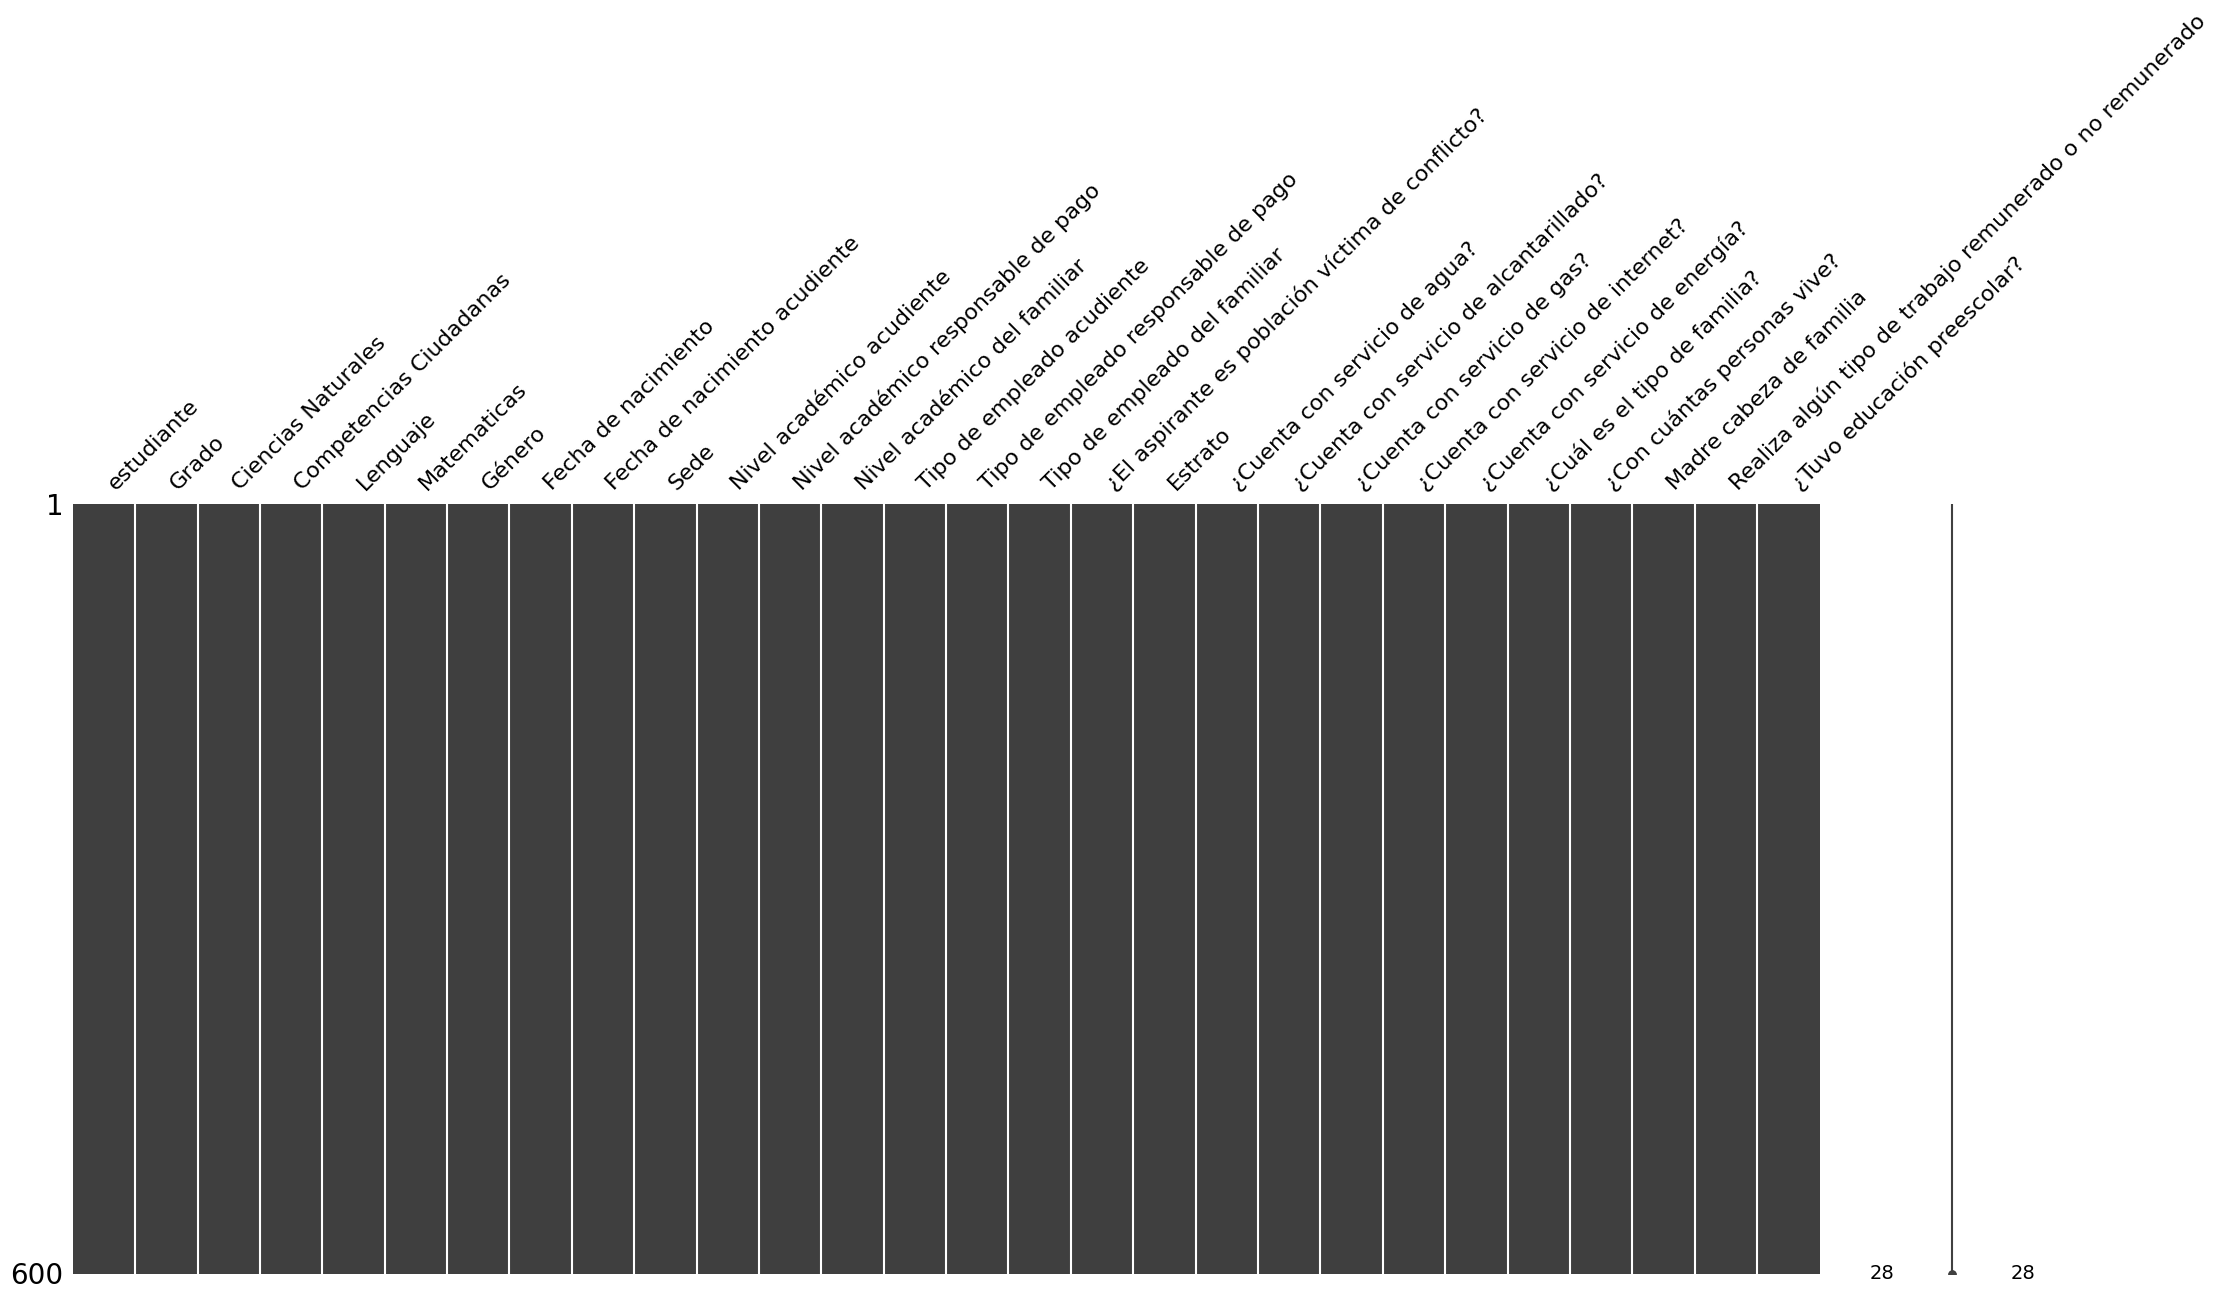

<Figure size 1500x900 with 0 Axes>

In [2001]:
# Plot de distribuición de NaNs

msno.matrix(clean_data)
plt.figure(figsize = (15,9))
plt.show()

## Encoding

Dado el dataset `clean_data`, el cual contiene tanto las variables académicas como las sociodemográficas, se procede a crear la matriz numérica por medio de técnicas de *encoding*. El proceso se divide en *encoding* de variables binarias y variables no-binarias. 

### Encoding variables binarias

In [2002]:
# Copia de dataframe `clean_data`

df_c = clean_data.copy()

In [2003]:
# Columnas binarias

binary_cols = [col for col in df_c.columns if df_c[col].nunique() == 2]

binary_cols

['Género',
 '¿El aspirante es población víctima de conflicto?',
 '¿Cuenta con servicio de agua?',
 '¿Cuenta con servicio de alcantarillado?',
 '¿Cuenta con servicio de gas?',
 '¿Cuenta con servicio de internet?',
 '¿Cuenta con servicio de energía?',
 'Madre cabeza de familia',
 'Realiza algún tipo de trabajo remunerado o no remunerado',
 '¿Tuvo educación preescolar?']

In [2004]:
# Exclusión de Género

df_sn = df_c[binary_cols].drop('Género', axis = 1)

In [2005]:
# Binary Mapping (Sí/No)

binary_mapping = {'Sí': 1, 'No': 0}

for col in df_sn:
  df_c[col] = df_c[col].map(binary_mapping)

In [2006]:
# Binary Mapping ('Género')

df_c['Género'] = df_c['Género'].map({'Femenino':0,'Masculino':1})

In [2007]:
# Dataframe `df_c` (variables binarias codificadas)

df_c

,estudiante,Grado,Ciencias Naturales,Competencias Ciudadanas,Lenguaje,Matematicas,Género,Fecha de nacimiento,Fecha de nacimiento acudiente,Sede,...,¿Cuenta con servicio de agua?,¿Cuenta con servicio de alcantarillado?,¿Cuenta con servicio de gas?,¿Cuenta con servicio de internet?,¿Cuenta con servicio de energía?,¿Cuál es el tipo de familia?,¿Con cuántas personas vive?,Madre cabeza de familia,Realiza algún tipo de trabajo remunerado o no remunerado,¿Tuvo educación preescolar?
0,76ef3a0b4b54a2b475f0cb110f84587529964fbc85be1b...,Sexto,0.70,1.00,0.80,0.90,0,2011-04-30,1973-08-14,Colegio Cosmo Schools Barrio Colombia,...,1,1,1,1,1,Nuclear,3,0,0,1
1,8871e8086ed25f710069df46ada73b1a1a0ece65004b3b...,Quinto,0.20,0.00,0.00,0.20,1,2011-06-21,1992-02-04,Colegio Cosmo Schools Barrio Colombia,...,1,1,1,1,1,Nuclear,2,0,0,1
2,0cfd67296291ad9cc47f89cdcab17d7857be7995b842d0...,Quinto,0.60,0.70,0.80,0.50,1,2012-11-28,1983-09-02,Colegio Cosmo Schools Robledo,...,1,1,1,1,1,De padres separados,2,1,0,1
3,5f9741102dab4a3840ac5ab46422bfae3ab5cc61e1106f...,Octavo,0.50,0.30,0.60,0.70,0,2009-04-12,1976-07-06,Colegio Cosmo Schools Cristo Rey,...,1,1,1,1,1,Nuclear,3,0,0,1
4,37cb04265accc31455ab43b436ce63d809e9b64d2060e9...,Sexto,0.30,0.60,0.80,0.70,1,2011-05-21,1983-12-25,Colegio Cosmo Schools Centro,...,1,1,1,1,1,De padres separados,2,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,008441312f9d4b26a3f6e2fa806021ee6a912db7305431...,Quinto,0.50,0.40,0.80,0.30,0,2012-08-23,1972-02-25,Colegio Cosmo Schools Barrio Colombia,...,1,1,1,1,1,De padres separados,5,0,0,1
596,f2905a9dbb74bbc617d663e2198e930433acef360a5c12...,Quinto,0.60,0.00,0.30,0.30,0,2012-04-23,1987-06-23,Colegio Comfama Rionegro,...,1,1,1,1,1,Nuclear,3,0,0,1
597,f21180ddb68ac70c139ff393f1a7afc4c58c6bd353ef3e...,Octavo,0.70,0.60,0.70,0.80,0,2009-07-10,1989-07-07,Colegio Cosmo Schools Centro,...,1,1,1,1,1,De padres separados,2,0,0,1
598,8bc1990395c34e0fdf01d6a1793032c0d4f30a49a6150b...,Quinto,0.50,0.30,0.40,0.40,0,2011-12-10,2011-12-10,Colegio Comfama Rionegro,...,1,1,1,1,1,De padres separados,3,0,0,1


### Encoding variables nominales y ordinales

In [2008]:
# Exploración de conteos de las variables

df_c.nunique()

estudiante                                                  600
Grado                                                        10
Ciencias Naturales                                           11
Competencias Ciudadanas                                      11
Lenguaje                                                     11
Matematicas                                                  11
Género                                                        2
Fecha de nacimiento                                         518
Fecha de nacimiento acudiente                               562
Sede                                                          6
Nivel académico acudiente                                    25
Nivel académico responsable de pago                          26
Nivel académico del familiar                                 27
Tipo de empleado acudiente                                    7
Tipo de empleado responsable de pago                          7
Tipo de empleado del familiar           

In [2009]:
df_c.columns

Index(['estudiante', 'Grado', 'Ciencias Naturales', 'Competencias Ciudadanas',
       'Lenguaje', 'Matematicas', 'Género', 'Fecha de nacimiento',
       'Fecha de nacimiento acudiente', 'Sede', 'Nivel académico acudiente',
       'Nivel académico responsable de pago', 'Nivel académico del familiar',
       'Tipo de empleado acudiente', 'Tipo de empleado responsable de pago',
       'Tipo de empleado del familiar',
       '¿El aspirante es población víctima de conflicto?', 'Estrato',
       '¿Cuenta con servicio de agua?',
       '¿Cuenta con servicio de alcantarillado?',
       '¿Cuenta con servicio de gas?', '¿Cuenta con servicio de internet?',
       '¿Cuenta con servicio de energía?', '¿Cuál es el tipo de familia?',
       '¿Con cuántas personas vive?', 'Madre cabeza de familia',
       'Realiza algún tipo de trabajo remunerado o no remunerado',
       '¿Tuvo educación preescolar?'],
      dtype='object')

In [2010]:
# Columna de Diferencia de edades entre estudiante y acudiente

df_c['Diferencia de Edades'] = ((df_c['Fecha de nacimiento'] - df_c['Fecha de nacimiento acudiente']) / pd.Timedelta(days=365)).astype(int)

In [2011]:
# Drop de Columnas de Fechas

df_c.drop(['Fecha de nacimiento', 'Fecha de nacimiento acudiente'], axis = 1, inplace=True)

In [2012]:
# Conversión de variable `Grado` a numéricos

grade_mapping = {'Quinto': 5, 'Sexto': 6, 'Septimo':7, 'Octavo':8, 'Noveno':9,'InspiraTec Noveno':9,'Decimo':10, 'InspiraTec Decimo':10, 'decimo':10, 'Nuevas Oportunidades 10-11':11}
df_c['Grado'] = df_c['Grado'].map(grade_mapping)

In [2013]:
# Conversión de variables de acudientes a variables numéricas

# Selección de variables
columnas = df_c.iloc[0, list(range(7,14)) + [21]].index

# Categorizador
categorizador = preprocessing.LabelEncoder()

for c in columnas:
  categorizador.fit(df_c[c])
  df_c[c] = categorizador.transform(df_c[c]) 

In [2014]:
# Conversión de variable 'Estrato' a Int

df_c['Estrato'] = df_c['Estrato'].astype(int)

In [2015]:
# Depuración de variable `¿Con cuántas personas vive?`

df_c['¿Con cuántas personas vive?'] = df_c['¿Con cuántas personas vive?'].replace('Más de 10', 10)
df_c['¿Con cuántas personas vive?'] = df_c['¿Con cuántas personas vive?'].astype(int)

In [2016]:
# Matriz Numérica!

df_numeric = df_c.copy()

## Estadística Descriptiva

Una vez creado el dataset `df_numeric`, el cual contiene codificadas tanto las variables académicas como las variables sociodemográficas, se procede a hacer un análisis descriptivo exploratorio. En concreto, se calculan diferentes tipos de correlación entre las variables. 

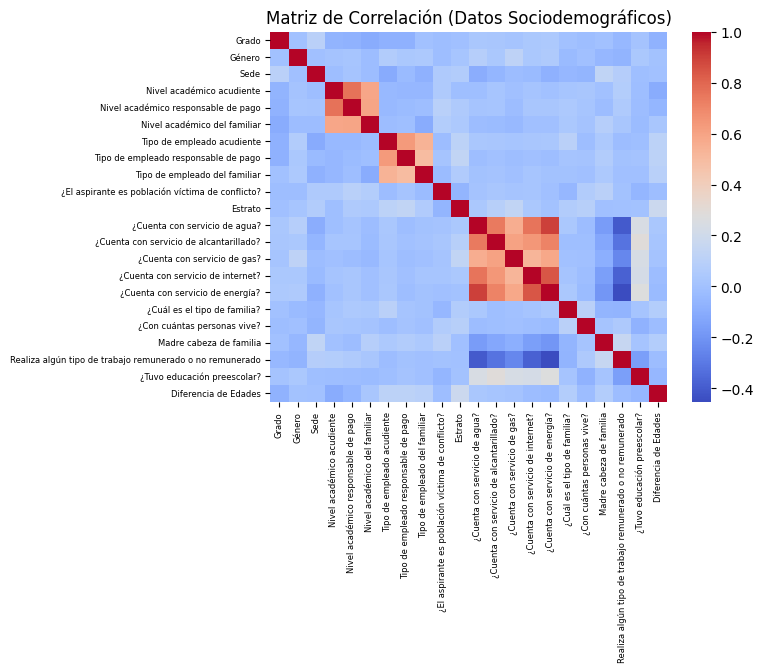

In [ ]:
# Matriz de Correlación de Variables Sociodemográficas

df_corr = df_numeric.iloc[:,[1] + list(range(6, 27))].corr()


# Plot Matriz Correlación 

sns.heatmap(df_corr, cmap='coolwarm')
plt.title('Matriz de Correlación (Datos Sociodemográficos)')

plt.xticks(fontsize=6)
plt.yticks(fontsize=6)

plt.show()



In [ ]:
# Correlación múltiple de variables sociodemográficas

# Matriz de covarianzas
S = df_numeric.cov().values

# Matriz Inversa de covarianzas
S_inv = np.linalg.inv(S)
S_inv.round(2)

Vector_Corre_Multiples = 1 - 1/ (np.diag(S) * np.diag(S_inv))
Vector_Corre_Multiples.round(4)

<ipython-input-40-b81cf818bb1f>:4: FutureWarning: The default value of numeric_only in DataFrame.cov is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  S = df_numeric.cov().values


array([0.187 , 0.1713, 0.4754, 0.4853, 0.4528, 0.0668, 0.0836, 0.6246,
       0.6347, 0.4349, 0.4945, 0.4572, 0.3542, 0.0517, 0.1219, 0.8382,
       0.6265, 0.4414, 0.727 , 0.8862, 0.0637, 0.0568, 0.116 , 0.2293,
       0.1279, 0.1032])

In [ ]:
Vector_Corre_Multiples[19] 
Vector_Corre_Multiples[15]

print(f'Las variables que mayor grado de predicción son: {df_c.columns[19],df_c.columns[15]}')

Las variables que mayor grado de predicción son: ('¿Cuenta con servicio de internet?', 'Estrato')


### Subplots de variables sociodemográficas







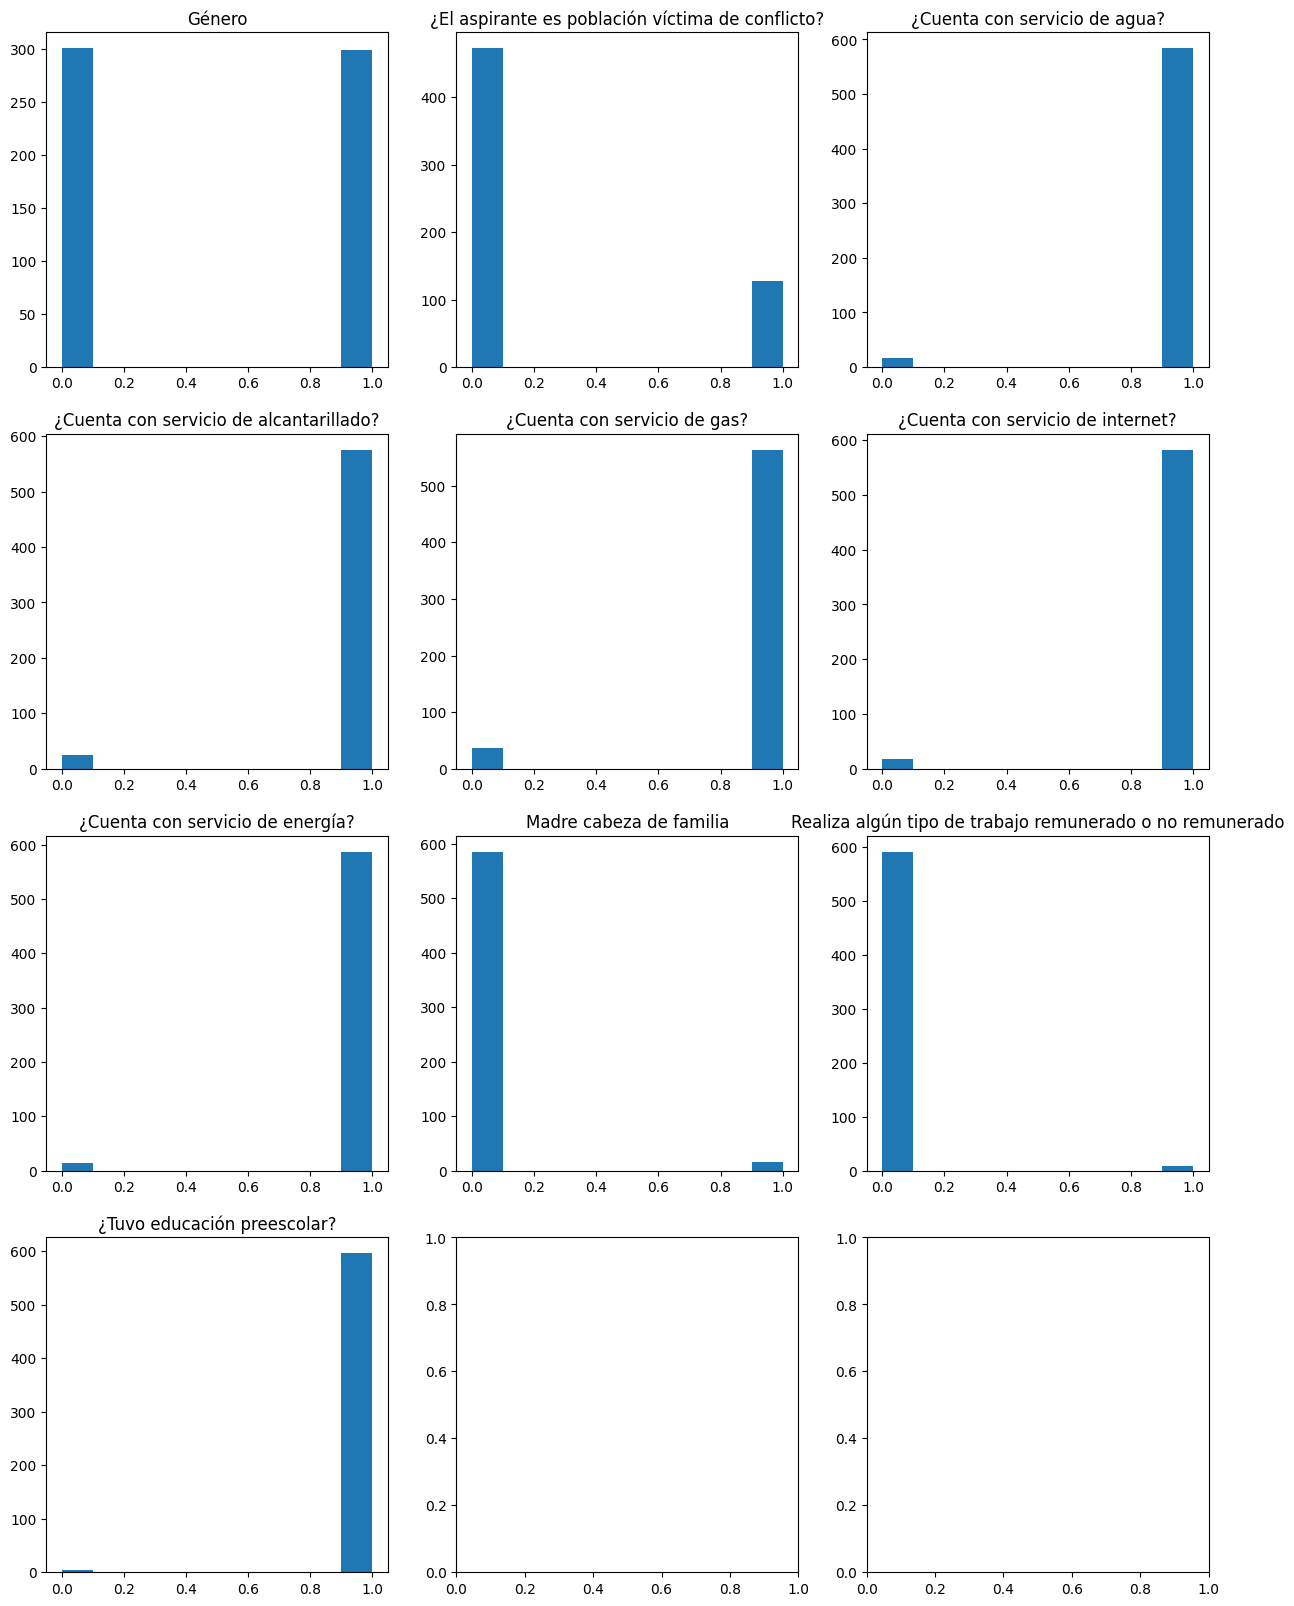

In [ ]:
# Plot the variables binarias
binary_cols

# non_bi_cols = [col for col in df_c.columns if df_c[col].nunique() != 2]
# non_bi_cols = non_bi_cols[6:-1]

# Numero de filas y columnas para subplots
num_rows = int(len(binary_cols)) // 3 + 1
num_cols = 3

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 5*num_rows))

# Plot binary variables
for i, var in enumerate(binary_cols):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].hist(df_c[var])
    axes[row, col].set_title(var)

In [ ]:
# Columnas != binarias

non_bi_cols = [col for col in df_c.columns if df_c[col].nunique() != 2]
non_bi_cols = non_bi_cols[6:-1]

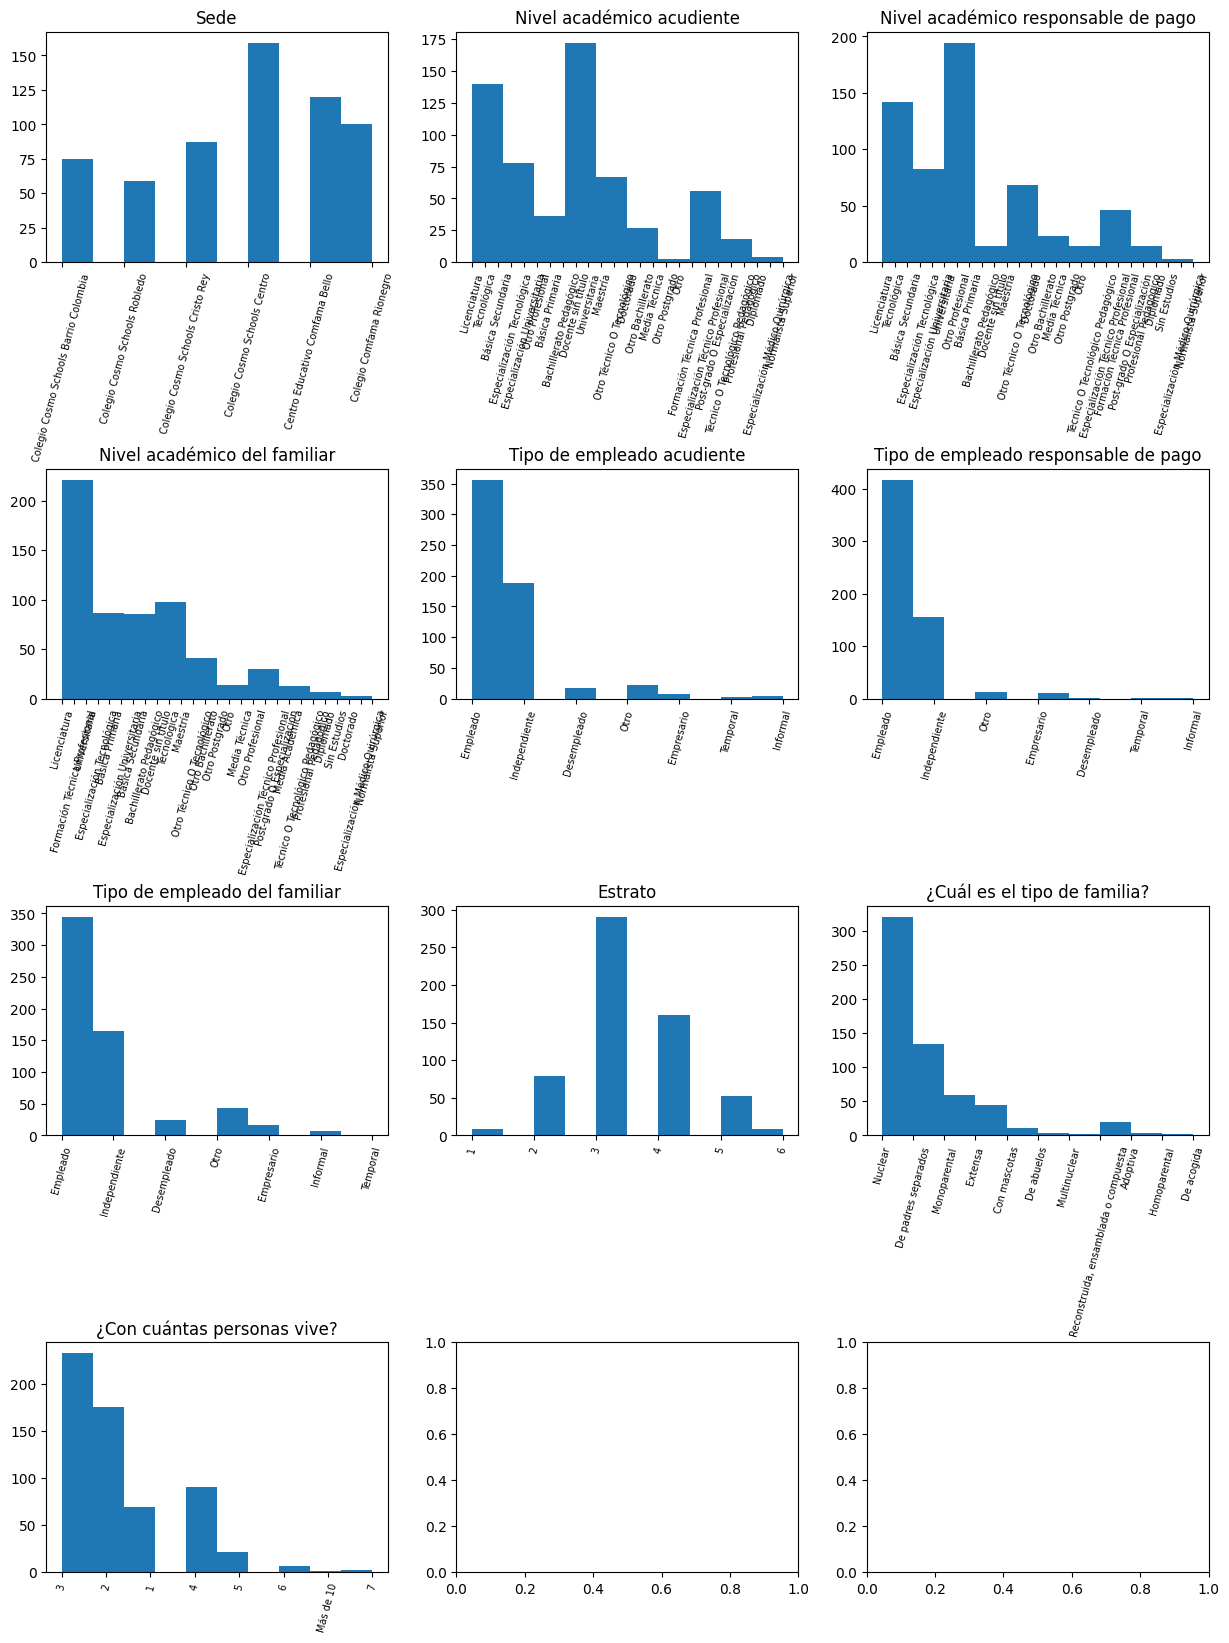

In [ ]:

# Calculate the number of rows and columns for subplots
num_rows = len(non_bi_cols) // 3 + 1
num_cols = 3

# Create subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 5*num_rows))

# Plot non-binary variables
for i, var in enumerate(non_bi_cols):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].hist(clean_data[var])
    axes[row, col].set_title(var)
    
    # Rotate x-axis ticks vertically
    axes[row, col].tick_params(axis='x', rotation=75, labelsize=7)
    
# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.9)

# Show the subplots
plt.show()


### Subplots de variables académicas

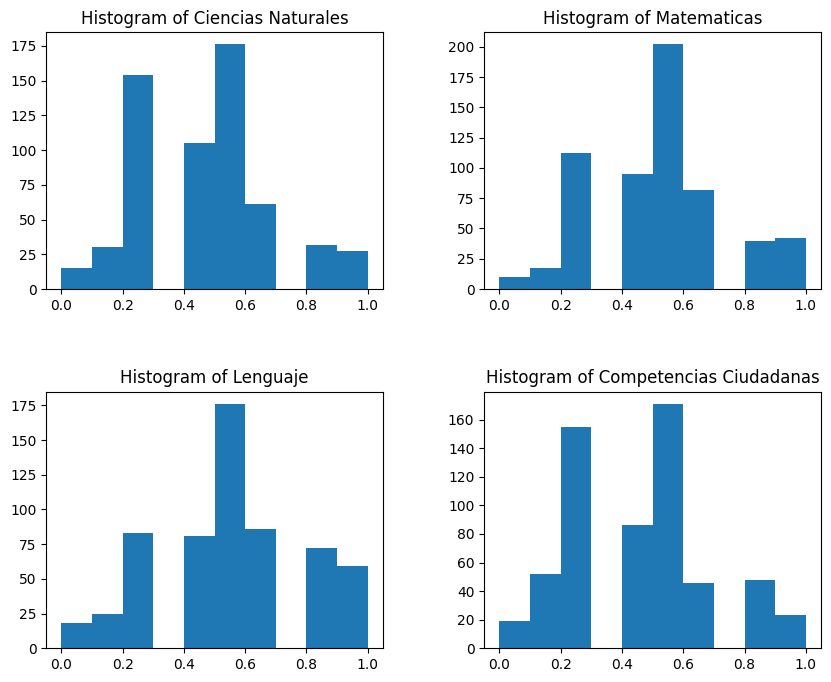

In [ ]:
# Detalles de distribucion de Evaluaciones

import matplotlib.pyplot as plt

# Datos de ejemplo
x = clean_data['Ciencias Naturales']
y = clean_data['Matematicas']
z = clean_data['Lenguaje']
w = clean_data['Competencias Ciudadanas']

# Crear la figura y los ejes
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Subplot 1 - Histogram of x
axs[0, 0].hist(x)
axs[0, 0].set_title('Histogram of Ciencias Naturales')

# Subplot 2 - Histogram of y
axs[0, 1].hist(y)
axs[0, 1].set_title('Histogram of Matematicas')

# Subplot 3 - Histogram of z
axs[1, 0].hist(z)
axs[1, 0].set_title('Histogram of Lenguaje')

# Subplot 4 - Histogram of w
axs[1, 1].hist(w)
axs[1, 1].set_title('Histogram of Competencias Ciudadanas')

# Ajustar el espacio entre los subplots
plt.subplots_adjust(wspace=0.3, hspace=0.4)

# Mostrar los gráficos
plt.show()


## Modelación

En esta sección se implementarán varios modelos de aprendizaje automatizado, tanto supervisados como no-supervisados. La lógica detrás de estos modelos será crear, con el dataset de valoraciones académicas, una variable *target*. Esta variable será precisamente la variable a predecir tomando como predictores las variables del dataset sociodemográfico. Se procede pues de la siguiente manera:

1. Estrategias para precisar la variable *target*. Para ello se usan modelos de aprendizaje no-supervisado. 
2. Selección y ajuste de variables predictoras. Para ello se usan modelos de aprendizaje supervisado. 


### Separación de matrices (X, Y)

In [ ]:
# Matriz materias (target)

matriz_materias = df_c.iloc[:,2:6]

In [ ]:
# Matriz atributos (predictores)

matriz_atr = df_c.iloc[:,6:]

### Target: Vector distancias al resultado ideal

#### Distancia Euclidea

In [ ]:
# Vector distancia de los datos al ideal
# Nota: El resultado ideal se toma como el vector [1, 1, 1, 1], que corresponde a un score perfecto en las 4 materias

y_euclidea_ideal = np.array([distance.euclidean(matriz_materias.iloc[d, :], np.array([1,1,1,1])) for d in range(len(matriz_materias))])

(array([  3.,  36.,  59.,  91., 123., 100., 105.,  42.,  29.,  12.]),
 array([0.2       , 0.37519221, 0.55038443, 0.72557664, 0.90076885,
        1.07596106, 1.25115328, 1.42634549, 1.6015377 , 1.77672992,
        1.95192213]),
 <BarContainer object of 10 artists>)

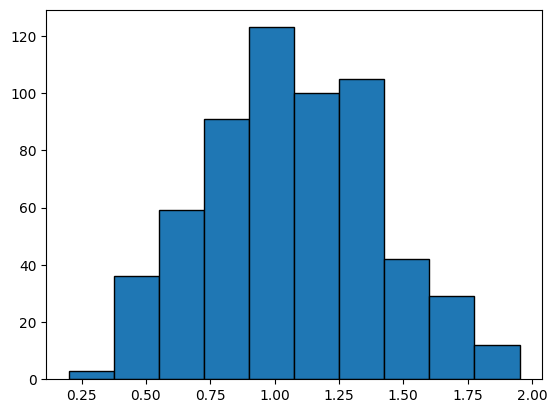

In [ ]:
# Plot de distancias al ideal 

## Nota: entre menor distancia, mejor el resultado!!

plt.hist(y_euclidea_ideal, bins=10, edgecolor='black')

In [ ]:
# Definición de percentiles para indexar 

perc_25 = np.percentile(y_euclidea_ideal, 25)
perc_50 = np.percentile(y_euclidea_ideal, 50)
perc_75 = np.percentile(y_euclidea_ideal, 75)


In [ ]:
# Definición de Corte Académico (Indices)

corte_sup = matriz_materias[y_euclidea_ideal <= perc_25].index
corte_medsup = matriz_materias[(perc_25 < y_euclidea_ideal) & (y_euclidea_ideal <= perc_50)].index
corte_medinf = matriz_materias[(perc_50 < y_euclidea_ideal) & (y_euclidea_ideal <= perc_75)].index
corte_inf = matriz_materias[perc_75 < y_euclidea_ideal].index


In [ ]:
# Vista de resultados corte inferior

matriz_materias.iloc[corte_inf,:].head(5)

,Ciencias Naturales,Competencias Ciudadanas,Lenguaje,Matematicas
1,0.20,0.00,0.00,0.20
5,0.00,0.10,0.10,0.40
13,0.10,0.20,0.10,0.20
15,0.50,0.20,0.50,0.20
16,0.40,0.40,0.50,0.10


In [ ]:
# Vista de resultados corte superior

matriz_materias.iloc[corte_sup,:].head(5)

,Ciencias Naturales,Competencias Ciudadanas,Lenguaje,Matematicas
0,0.70,1.00,0.80,0.90
2,0.60,0.70,0.80,0.50
8,0.80,1.00,1.00,1.00
9,0.80,0.80,0.80,0.80
21,0.60,0.90,0.90,0.60


In [ ]:
# Matriz con vector target (Creación Vector Y = [])

matriz_materias_classified = matriz_materias.copy()
matriz_materias_classified['Y'] = ""

In [ ]:
# Poblar vector target

matriz_materias_classified.loc[corte_sup, 'Y'] = 3 # Corte Superior
matriz_materias_classified.loc[corte_medsup, 'Y'] = 2 # Corte Medio-Superior
matriz_materias_classified.loc[corte_medinf, 'Y'] = 1 # Corte Medio-Inferior
matriz_materias_classified.loc[corte_inf, 'Y'] = 0 # Corte Inferior

In [ ]:
# Matriz con vector target dado por distancia al ideal

matriz_materias_classified

,Ciencias Naturales,Competencias Ciudadanas,Lenguaje,Matematicas,Y
0,0.70,1.00,0.80,0.90,3
1,0.20,0.00,0.00,0.20,0
2,0.60,0.70,0.80,0.50,3
3,0.50,0.30,0.60,0.70,2
4,0.30,0.60,0.80,0.70,2
...,...,...,...,...,...
595,0.50,0.40,0.80,0.30,1
596,0.60,0.00,0.30,0.30,0
597,0.70,0.60,0.70,0.80,3
598,0.50,0.30,0.40,0.40,1


In [ ]:
# Vector target de distancias euclidea ideales

Y_dist_ideal = matriz_materias_classified['Y']

In [ ]:
# Correlación múltiple de variables con target ['Y']

# Creación de matriz con atributos y target

matriz_corr_target = matriz_atr.copy()

matriz_corr_target['clasificacion'] = Y_dist_ideal.astype(int)

# Matriz de covarianzas

S_ = matriz_corr_target.cov().values

# Matriz Inversa de covarianzas
S_inv_ = np.linalg.inv(S_)
S_inv_.round(2)

Vector_Corre_Multiples_target = 1 - 1/ (np.diag(S_) * np.diag(S_inv_))
Vector_Corre_Multiples_target.round(4)

array([0.0405, 0.0652, 0.6246, 0.6336, 0.4287, 0.4907, 0.4557, 0.3513,
       0.0503, 0.1172, 0.8358, 0.6255, 0.4373, 0.725 , 0.8851, 0.0626,
       0.0418, 0.109 , 0.2271, 0.1212, 0.0952, 0.0337])

In [ ]:
# Variable de correlación múltiple

correlacion_multiple = dict(zip(matriz_corr_target.columns, Vector_Corre_Multiples_target ))

In [ ]:
variables_df = {}
for i,v in (enumerate(matriz_corr_target.columns)):
  print(f'{i} -> {v}')
  variables_df[v] = i

0 -> Género
1 -> Sede
2 -> Nivel académico acudiente
3 -> Nivel académico responsable de pago
4 -> Nivel académico del familiar
5 -> Tipo de empleado acudiente
6 -> Tipo de empleado responsable de pago
7 -> Tipo de empleado del familiar
8 -> ¿El aspirante es población víctima de conflicto?
9 -> Estrato
10 -> ¿Cuenta con servicio de agua?
11 -> ¿Cuenta con servicio de alcantarillado?
12 -> ¿Cuenta con servicio de gas?
13 -> ¿Cuenta con servicio de internet?
14 -> ¿Cuenta con servicio de energía?
15 -> ¿Cuál es el tipo de familia?
16 -> ¿Con cuántas personas vive?
17 -> Madre cabeza de familia
18 -> Realiza algún tipo de trabajo remunerado o no remunerado
19 -> ¿Tuvo educación preescolar?
20 -> Diferencia de Edades
21 -> clasificacion


In [ ]:
len(Vector_Corre_Multiples_target)

22

#### Distancia Mahalanobis

In [ ]:
#Número de condición matriz materias
np.linalg.cond(matriz_materias.cov())

5.885725756130182

In [ ]:
# Vector distancia de los datos al ideal (Distancia Mahalanobis)

# Nota: El resultado ideal se toma como el vector [1, 1, 1, 1], que corresponde a un score perfecto en las 4 materias

# Creación de la matriz VI (Inversa de la covarianza de los datos originales (?))

S = matriz_materias.cov()
S_inv = np.linalg.inv(S)

# Matriz de resultados a ideal

ideal = np.array([1,1,1,1])

matriz_centrada = matriz_materias - ideal

# Definición de función Distancia Mahalanobis

def dist_mahalanobis(x, VI):
  mahal = np.sqrt(x @ VI @ x.T)
  return mahal

# Distancia Mahalanobis (Iteración)

y_mahal_ideal = [dist_mahalanobis(matriz_centrada.iloc[i,:], S_inv) for i in range(len(matriz_centrada))]

(array([  6.,  28.,  44.,  74., 110., 115., 108.,  76.,  29.,  10.]),
 array([0.98960755, 1.48132553, 1.97304351, 2.46476149, 2.95647948,
        3.44819746, 3.93991544, 4.43163342, 4.92335141, 5.41506939,
        5.90678737]),
 <BarContainer object of 10 artists>)

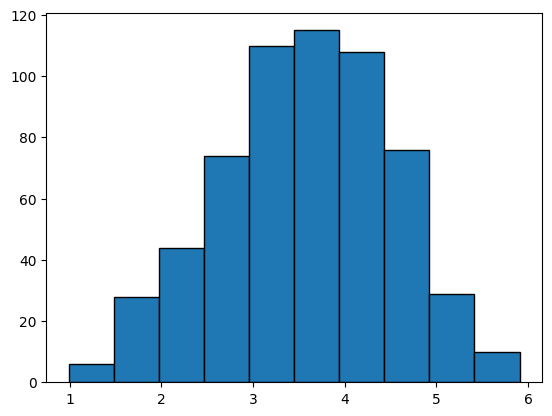

In [ ]:
# Plot de distancias al ideal 

## Nota: entre menor distancia, mejor el resultado!!

plt.hist(y_mahal_ideal, bins=10, edgecolor='black')

In [ ]:
# Definición de percentiles para indexar 

perc_25_mahal = np.percentile(y_mahal_ideal, 25)
perc_50_mahal = np.percentile(y_mahal_ideal, 50)
perc_75_mahal = np.percentile(y_mahal_ideal, 75)


In [ ]:
# Definición de Corte Académico (Indices)

corte_sup_mahal = matriz_materias[y_mahal_ideal <= perc_25_mahal].index
corte_medsup_mahal = matriz_materias[(perc_25_mahal < y_mahal_ideal) & (y_mahal_ideal <= perc_50_mahal)].index
corte_medinf_mahal = matriz_materias[(perc_50_mahal < y_mahal_ideal) & (y_mahal_ideal <= perc_75_mahal)].index
corte_inf_mahal = matriz_materias[perc_75_mahal < y_mahal_ideal].index


In [ ]:
# Vista de resultados corte inferior

matriz_materias.iloc[corte_inf_mahal,:].head(5)

,Ciencias Naturales,Competencias Ciudadanas,Lenguaje,Matematicas
1,0.20,0.00,0.00,0.20
5,0.00,0.10,0.10,0.40
12,0.40,0.10,0.70,0.40
13,0.10,0.20,0.10,0.20
15,0.50,0.20,0.50,0.20


In [ ]:
# Vista de resultados corte superior

matriz_materias.iloc[corte_sup_mahal,:].head(5)

,Ciencias Naturales,Competencias Ciudadanas,Lenguaje,Matematicas
0,0.70,1.00,0.80,0.90
2,0.60,0.70,0.80,0.50
8,0.80,1.00,1.00,1.00
9,0.80,0.80,0.80,0.80
21,0.60,0.90,0.90,0.60


In [ ]:
# Matriz con vector target (Creación Vector Y = [])

matriz_materias_mahal_classified = matriz_materias.copy()

matriz_materias_mahal_classified['Y'] = ""

In [ ]:
# Poblar vector target

matriz_materias_mahal_classified.loc[corte_sup, 'Y'] = 3 # Corte Superior
matriz_materias_mahal_classified.loc[corte_medsup, 'Y'] = 2 # Corte Medio-Superior
matriz_materias_mahal_classified.loc[corte_medinf, 'Y'] = 1 # Corte Medio-Inferior
matriz_materias_mahal_classified.loc[corte_inf, 'Y'] = 0 # Corte Inferior

In [ ]:
# Matriz con vector target dado por distancia al ideal

matriz_materias_classified

,Ciencias Naturales,Competencias Ciudadanas,Lenguaje,Matematicas,Y
0,0.70,1.00,0.80,0.90,3
1,0.20,0.00,0.00,0.20,0
2,0.60,0.70,0.80,0.50,3
3,0.50,0.30,0.60,0.70,2
4,0.30,0.60,0.80,0.70,2
...,...,...,...,...,...
595,0.50,0.40,0.80,0.30,1
596,0.60,0.00,0.30,0.30,0
597,0.70,0.60,0.70,0.80,3
598,0.50,0.30,0.40,0.40,1


In [ ]:
# Vector target de distancias ideales

Y_dist_ideal_mahal = matriz_materias_mahal_classified['Y']

### Target: K-means

In [ ]:
# Matriz materias

matriz_k_means = matriz_materias.copy()

In [ ]:
# Modelo K-means

from sklearn.cluster import KMeans
import numpy as np

km = KMeans (n_clusters=3)
y_predicted = km.fit_predict(matriz_k_means[['Ciencias Naturales', 'Competencias Ciudadanas', 'Lenguaje',
       'Matematicas']])


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
# Creación de columna `cluster` para aislar los resultados

matriz_k_means['Y'] = y_predicted

In [ ]:
# Descripción estadísticas de clustering

print(matriz_k_means[matriz_k_means['Y'] == 0 ].iloc[:,:-1].describe())
print()
print(matriz_k_means[matriz_k_means['Y'] == 1 ].iloc[:,:-1].describe())
print()
print(matriz_k_means[matriz_k_means['Y'] == 2 ].iloc[:,:-1].describe())
print()

### Se percibe que los clusters están distribuidos de la siguiente manera: 
## Cluster 0: Estudiantes de bajo rendimiento
## Cluster 1: Estudiantes de alto rendimiento
## Cluster 2: Estudiantes de mediano rendimiento 


       Ciencias Naturales  Competencias Ciudadanas  Lenguaje  Matematicas
count              190.00                   190.00    190.00       190.00
mean                 0.31                     0.23      0.29         0.33
std                  0.18                     0.14      0.16         0.17
min                  0.00                     0.00      0.00         0.00
25%                  0.20                     0.10      0.20         0.20
50%                  0.30                     0.20      0.30         0.30
75%                  0.40                     0.30      0.40         0.40
max                  0.80                     0.70      0.70         0.80

       Ciencias Naturales  Competencias Ciudadanas  Lenguaje  Matematicas
count              179.00                   179.00    179.00       179.00
mean                 0.57                     0.70      0.77         0.72
std                  0.19                     0.13      0.14         0.16
min                  0.10            

In [ ]:
# Idx de diferentes clusters

idx_0 = matriz_k_means[matriz_k_means['Y'] == 0 ].iloc[:,:-1].index # bajo rendimiento
idx_1 = matriz_k_means[matriz_k_means['Y'] == 1 ].iloc[:,:-1].index # alto rendimiento
idx_2 = matriz_k_means[matriz_k_means['Y'] == 2 ].iloc[:,:-1].index # mediano rendimiento

In [ ]:
# Conteo de estudiantes por cluster

bajo_rend = len(idx_0)
alto_rend = len(idx_1)
med_rend = len(idx_2)

print(f'Estudiantes de bajo rendimiento: {bajo_rend}')
print()
print(f'Estudiantes de alto rendimiento: {alto_rend}')
print()
print(f'Estudiantes de mediano rendimiento: {med_rend}')

Estudiantes de bajo rendimiento: 190

Estudiantes de alto rendimiento: 179

Estudiantes de mediano rendimiento: 231


In [ ]:
# Correlación múltiple de variables con target ['Y']

# Creación de matriz con atributos y target

matriz_corr_kmeans = matriz_atr.copy()

matriz_corr_kmeans['Y'] = y_predicted

# Matriz de covarianzas

S_kmeans = matriz_corr_kmeans.cov().values

# Matriz Inversa de covarianzas
S_inv_kmeans = np.linalg.inv(S_kmeans)
S_inv_kmeans.round(2)

Vector_Multiples_kmeans = 1 - 1/ (np.diag(S_kmeans) * np.diag(S_inv_kmeans))
Vector_Multiples_kmeans.round(4)

array([0.04  , 0.0673, 0.6248, 0.6339, 0.4288, 0.492 , 0.4537, 0.3504,
       0.0503, 0.1172, 0.8357, 0.6246, 0.4364, 0.7251, 0.8854, 0.0563,
       0.0421, 0.1029, 0.2281, 0.1211, 0.0964, 0.0289])

### Predictores: Refinamiento de dataframe sociodemográfico

In [ ]:
# Copia del DataFrame `df_c` para hacer reducción

df_c_reduc = df_c.copy()

In [ ]:
# Enumeración de Columnas a Reducir

for c, v in enumerate(df_c_reduc.columns):
  print(f'{c} -> {v}')

0 -> estudiante
1 -> Grado
2 -> Ciencias Naturales
3 -> Competencias Ciudadanas
4 -> Lenguaje
5 -> Matematicas
6 -> Género
7 -> Sede
8 -> Nivel académico acudiente
9 -> Nivel académico responsable de pago
10 -> Nivel académico del familiar
11 -> Tipo de empleado acudiente
12 -> Tipo de empleado responsable de pago
13 -> Tipo de empleado del familiar
14 -> ¿El aspirante es población víctima de conflicto?
15 -> Estrato
16 -> ¿Cuenta con servicio de agua?
17 -> ¿Cuenta con servicio de alcantarillado?
18 -> ¿Cuenta con servicio de gas?
19 -> ¿Cuenta con servicio de internet?
20 -> ¿Cuenta con servicio de energía?
21 -> ¿Cuál es el tipo de familia?
22 -> ¿Con cuántas personas vive?
23 -> Madre cabeza de familia
24 -> Realiza algún tipo de trabajo remunerado o no remunerado
25 -> ¿Tuvo educación preescolar?
26 -> Diferencia de Edades


In [ ]:
# Reducción de columnas de servicios públicos

df_c_reduc.columns[16:21]

Index(['¿Cuenta con servicio de agua?',
       '¿Cuenta con servicio de alcantarillado?',
       '¿Cuenta con servicio de gas?', '¿Cuenta con servicio de internet?',
       '¿Cuenta con servicio de energía?'],
      dtype='object')

In [ ]:
# Variable servicios publicos unificada

df_c_reduc['servicios_pub'] = 0

for i in range(len(df_c_reduc)):
  if df_c_reduc.iloc[i, 16:21].sum() == 5:
    df_c_reduc.at[i, 'servicios_pub'] = 1

# Drop de columnas servicios públicos

df_c_reduc_ = df_c_reduc.drop(df_c_reduc.columns[16:21], axis=1)

In [ ]:
# Drop variables acudiente / responsable pago

df_c_reduc__ = df_c_reduc_.drop(df_c_reduc_.columns[[9,10,12,13]], axis=1)


In [ ]:
# Correlación múltiple de variables con target ['Y']

# Creación de matriz con atributos y target

matriz_corr_target = df_c_reduc__.iloc[:, [1] + list(range(6,19))]

matriz_corr_target['clasificacion'] = Y_dist_ideal.astype(int)

# Matriz de covarianzas

S_ = matriz_corr_target.cov().values

# Matriz Inversa de covarianzas
S_inv_ = np.linalg.inv(S_)
S_inv_.round(2)

Vector_Corre_Multiples_target = 1 - 1 / (np.diag(S_) * np.diag(S_inv_))
Vector_Corre_Multiples_target.round(4)

<ipython-input-1535-fb96296a2ea9>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matriz_corr_target['clasificacion'] = Y_dist_ideal.astype(int)


array([0.1395, 0.0254, 0.0592, 0.027 , 0.0595, 0.0356, 0.0891, 0.0519,
       0.0405, 0.0744, 0.1031, 0.0733, 0.072 , 0.1177, 0.1344])

#### Modelos Df reducido

In [ ]:
# Label para la predicción

Y = Y_dist_ideal.astype(int)

In [ ]:
# Modelo de Classificador Decision Tree Classifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

In [ ]:
# Splitting the data

X_trainset, X_testset, y_trainset, y_testset = train_test_split(df_c_reduc__.iloc[:, [1] + list(range(6,19))], Y, test_size=0.3, random_state=3)

tree_class = DecisionTreeClassifier(criterion="entropy", max_depth = 4, random_state=3)

tree_class.fit(X_trainset, y_trainset)


DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=3)

In [ ]:
# Precisión

acc = np.mean(tree_class.predict(X_testset) == y_testset).round(4)

print(f'La precisión del modelo Tree Classifier es de {acc * 100} %')

La precisión del modelo Tree Classifier es de 45.0 %


In [ ]:
from sklearn import metrics

print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_testset, tree_class.predict(X_testset)))

DecisionTrees's Accuracy:  0.45


In [ ]:
df_c_reduc.iloc[:, 1:]

,Grado,Ciencias Naturales,Competencias Ciudadanas,Lenguaje,Matematicas,Género,Sede,Nivel académico acudiente,Nivel académico responsable de pago,Nivel académico del familiar,...,¿Cuenta con servicio de gas?,¿Cuenta con servicio de internet?,¿Cuenta con servicio de energía?,¿Cuál es el tipo de familia?,¿Con cuántas personas vive?,Madre cabeza de familia,Realiza algún tipo de trabajo remunerado o no remunerado,¿Tuvo educación preescolar?,Diferencia de Edades,servicios_pub
0,6,0.70,1.00,0.80,0.90,0,2,11,11,11,...,1,1,1,9,3,0,0,1,37,1
1,5,0.20,0.00,0.00,0.20,1,2,22,23,10,...,1,1,1,9,2,0,0,1,19,1
2,5,0.60,0.70,0.80,0.50,1,5,2,2,26,...,1,1,1,4,2,1,0,1,29,1
3,8,0.50,0.30,0.60,0.70,0,4,7,7,7,...,1,1,1,9,3,0,0,1,32,1
4,6,0.30,0.60,0.80,0.70,1,3,9,9,10,...,1,1,1,4,2,0,0,1,27,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,5,0.50,0.40,0.80,0.30,0,2,24,10,10,...,1,1,1,4,5,0,0,1,40,1
596,5,0.60,0.00,0.30,0.30,0,1,24,25,26,...,1,1,1,9,3,0,0,1,24,1
597,8,0.70,0.60,0.70,0.80,0,3,12,12,12,...,1,1,1,4,2,0,0,1,20,1
598,5,0.50,0.30,0.40,0.40,0,1,24,25,26,...,1,1,1,4,3,0,0,1,0,1


## Modelos

### Model Decision Tree Classifier

#### Modelos: Decision Tree Classifier (Distancia Euclidea)

In [ ]:
# Label para la predicción

Y = Y_dist_ideal.astype(int)

In [ ]:
# Modelo de Classificador Decision Tree Classifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

In [ ]:
# Splitting the data

X_trainset, X_testset, y_trainset, y_testset = train_test_split(X_mod1, Y, test_size=0.3, random_state=3)

tree_class = DecisionTreeClassifier(criterion="entropy", max_depth = 4, random_state=3)

tree_class.fit(X_trainset, y_trainset)


DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=3)

In [ ]:
# Precisión

acc = np.mean(tree_class.predict(X_testset) == y_testset).round(4)

print(f'La precisión del modelo Tree Classifier es de {acc * 100} %')

La precisión del modelo Tree Classifier es de 26.11 %


#### Modelos: Decision Tree Classifier (K-means)

In [ ]:
# Label para la predicción

Y_ = y_predicted

In [ ]:
# Modelo de Classificador Decision Tree Classifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

# Splitting the data

X_trainset, X_testset, y_trainset, y_testset = train_test_split(X_mod1, Y_, test_size=0.3, random_state=3)

tree_class = DecisionTreeClassifier(criterion="entropy", max_depth = 4, random_state=3)

tree_class.fit(X_trainset, y_trainset)


DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=3)

In [ ]:
# Precisión

acc = np.mean(tree_class.predict(X_testset) == y_testset).round(4)

print(f'La precisión del modelo Tree Classifier es de {acc * 100} %')

La precisión del modelo Tree Classifier es de 41.67 %


### Model Random Forest

#### Modelos: Random Forest (Distancia Euclidea)

In [ ]:
# Label para la predicción
X_mod1=matriz_atr.copy()
Y = Y_dist_ideal.astype(int)

In [ ]:
# Modelo de Classificador Random Forest

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [ ]:
# Splitting the data

X_trainset, X_testset, y_trainset, y_testset = train_test_split(X_mod1, Y, test_size=0.3, random_state=3)

forest = RandomForestClassifier(criterion='gini', n_estimators=100)

forest.fit(X_trainset, y_trainset)


RandomForestClassifier()

In [ ]:
# Precisión

acc = np.mean(forest.predict(X_testset) == y_testset).round(4)

print(f'La precisión del modelo Random Forest es de {acc * 100} %')

La precisión del modelo Random Forest es de 21.11 %


#### Modelos: Random Forest (K-means)

In [ ]:
# Label para la predicción

Y_ = y_predicted

In [ ]:
# Modelo de Classificador Random Forest

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [ ]:
# Splitting the data

X_trainset, X_testset, y_trainset, y_testset = train_test_split(X_mod1, Y_, test_size=0.3, random_state=3)

forest = RandomForestClassifier(criterion='gini', n_estimators=100)

forest.fit(X_trainset, y_trainset)


RandomForestClassifier()

In [ ]:
# Precisión

acc = np.mean(forest.predict(X_testset) == y_testset).round(4)

print(f'La precisión del modelo Random Forest es de {acc * 100} %')

La precisión del modelo Random Forest es de 33.89 %


### Model Support Vector Machine


#### Modelos: SVM (Distancia Euclidea)

In [ ]:
from sklearn.svm import SVC
X_trainset, X_testset, y_trainset, y_testset = train_test_split(X_mod1, Y, test_size=0.3, random_state=3)
clf = SVC(kernel='linear')
clf.fit(X_trainset, y_trainset)
predictions = clf.predict(X_testset)



In [ ]:
acc=metrics.accuracy_score(y_testset, tree_class.predict(X_testset))

print(f'La precisión del modelo Random Forest es de {acc * 100} %')

La precisión del modelo Random Forest es de 28.888888888888886 %


#### Modelos: SVM (K-means)

In [ ]:
from sklearn.svm import SVC
X_trainset, X_testset, y_trainset, y_testset = train_test_split(X_mod1, Y_, test_size=0.3, random_state=3)
clf = SVC(kernel='linear')
clf.fit(X_trainset, y_trainset)
predictions = clf.predict(X_testset)



In [ ]:
acc=metrics.accuracy_score(y_testset, tree_class.predict(X_testset))
print(f'La precisión del modelo Random Forest es de {acc * 100} %')

La precisión del modelo Random Forest es de 41.66666666666667 %


# Metodo 2: Depuración de variables por métodos estadísticos


## Preprocesamiento 

**Nota**: En esta sección se hace una limpieza de los datasets. A diferencia de la relación entre los datasets que se aplicó en el método 1, la seleccionan de las variables del dataset `estudiates` se hace por medio de métodos estadísticos.

>En el dataset `linea_base` se seleccionan las cuatro asignaturas generales.

>En el dataset `estudiantes` se discriminan las variables por su variabilidad, correlación y  valor predictivo. Se descartan algunas variables por su baja calidad. 

**Nota**: Denotamos variables de baja calidad a aquellas que no están lo suficientemente pobladas en el dataset. 

In [ ]:
# Selección de Variables de Resultados en DataFrame `linea_base`

resultadosPruebas = linea_base[['estudiante','Grado','Ciencias Naturales',
       'Competencias Ciudadanas', 'Lenguaje', 'Matematicas']]

In [ ]:
resultados = resultadosPruebas[['estudiante','Ciencias Naturales',
                                'Competencias Ciudadanas', 'Lenguaje', 'Matematicas']].dropna()
resultados.reset_index(drop=True, inplace=True)

In [ ]:
df_merged = estudiantes.merge(resultados, how = 'inner', left_on='id_estudiante', right_on='estudiante')

In [ ]:
# Conteo de NaNs por fila

df_merged['Conteo_NaNs'] = ""

# Obtener los IDs únicos de los estudiantes en una lista
ids_unicos = df_merged['id_estudiante'].unique().tolist()

# Iterar sobre cada ID único
for i in ids_unicos:
    # Obtener los índices de las filas correspondientes a ese ID
    lista_indices_filas = df_merged[df_merged['id_estudiante'] == i].index.tolist()
    
    # Iterar sobre cada índice de fila
    for idx in lista_indices_filas:
        # Calcular la suma de valores nulos en la fila actual
        suma_nulos = df_merged.iloc[idx, :].isnull().sum()
        
        # Asignar la suma de nulos a la columna 'conteo_nulos' en la fila actual
        df_merged.at[idx, 'Conteo_NaNs'] = suma_nulos

In [ ]:
df_merged_ = df_merged.sort_values(by=['id_estudiante', 'Conteo_NaNs'], ignore_index=True)

df_merged_['conteo'] = df_merged_.groupby(['id_estudiante']).cumcount()

df_merged_ = df_merged_.drop_duplicates('id_estudiante', ignore_index=True)

In [ ]:
df_merged_['conteo'].unique()

array([0])

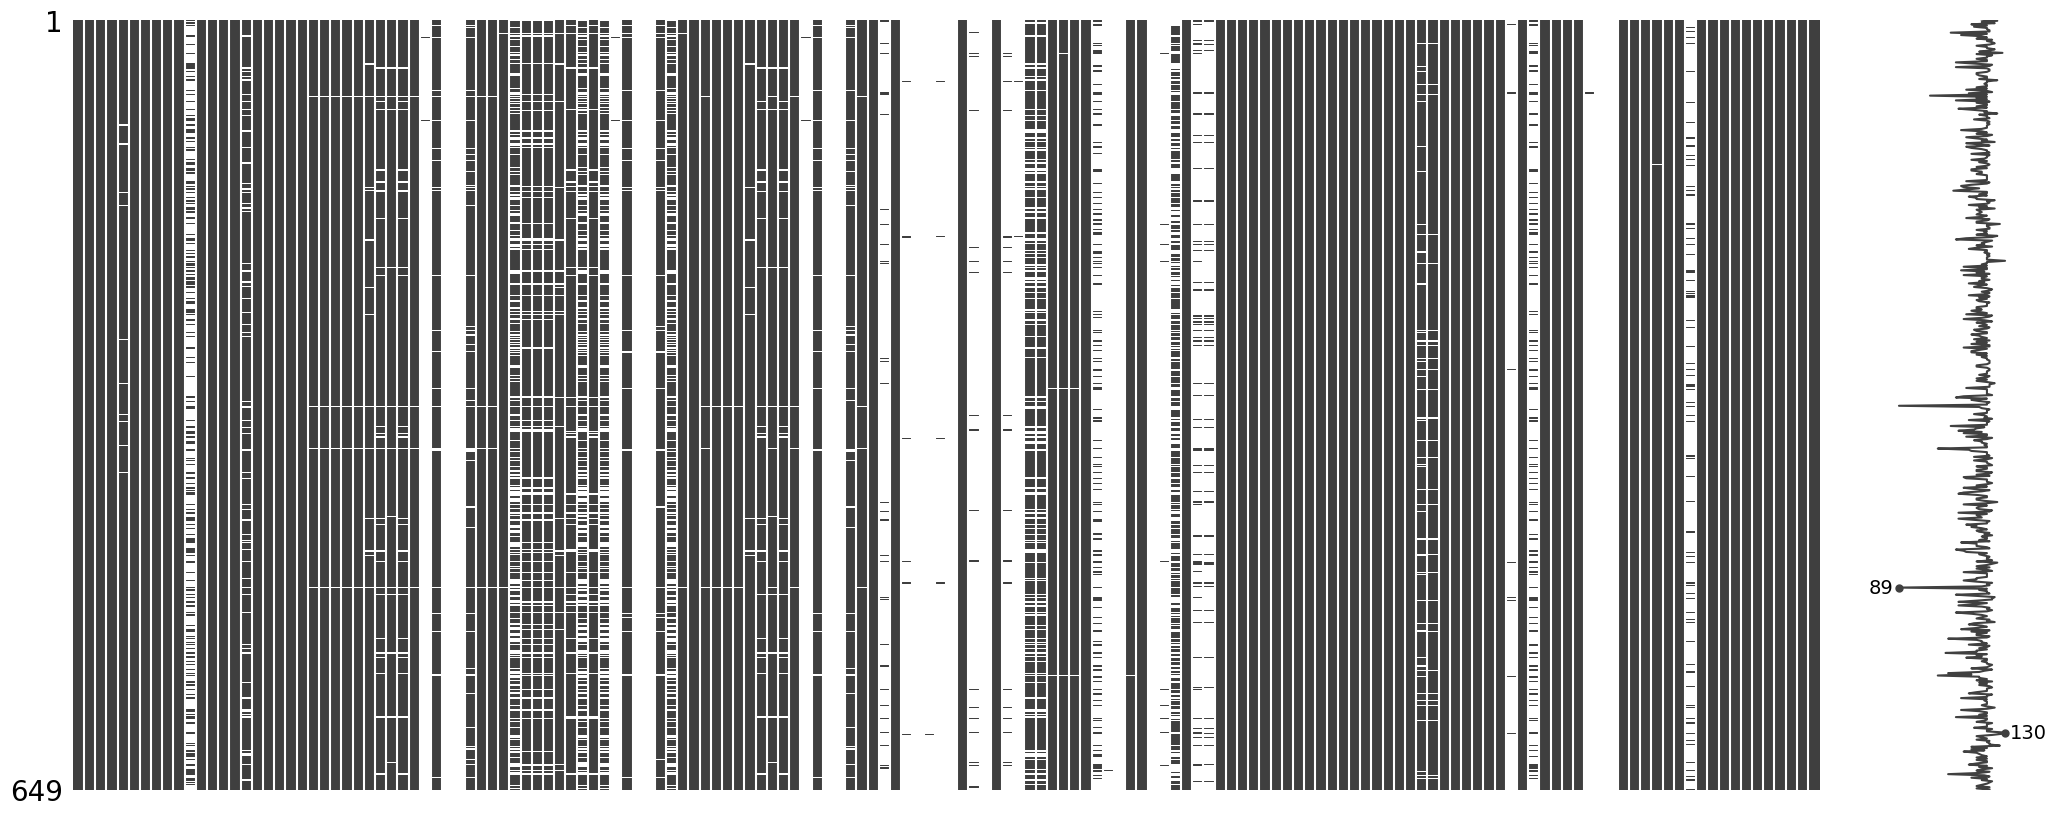

<Figure size 1500x900 with 0 Axes>

In [ ]:
msno.matrix(df_merged_)
plt.figure(figsize = (15,9))
plt.show()

In [ ]:
# Eliminamos columnas con alto porcentaje de valores nulos
columnas_eliminar = []
columnas = list(df_merged_.columns)
columa_porcentaje = {}

for i in range(len(columnas)):
  porcentaje_nulos = df_merged_.iloc[:, i].isnull().sum() / len(df_merged_)
  columa_porcentaje[columnas[i]] =  porcentaje_nulos
  
  if porcentaje_nulos >= 0.08:
    columnas_eliminar.append(columnas[i])

In [ ]:
len(columnas_eliminar)

44

In [ ]:
# eliminar columnas con más de 92% de los datos en NA
df_filt_nulls = df_merged_.drop(columnas_eliminar, axis=1)

In [ ]:
#Conteo de datos por categoría en las variables
for col in list(df_filt_nulls.columns[2:]):
  print(df_filt_nulls[col].value_counts() / len(df_filt_nulls))
  print()

Femenino    0.51
Masculino   0.49
Name: Género, dtype: float64

2011-04-28   0.01
2011-06-30   0.01
2011-10-15   0.00
2010-12-22   0.00
2012-03-20   0.00
             ... 
2007-10-15   0.00
2012-09-22   0.00
2009-12-10   0.00
2011-10-26   0.00
2009-04-13   0.00
Name: Fecha de nacimiento, Length: 555, dtype: float64

Medellín               0.77
Rionegro               0.07
Bogotá                 0.04
Envigado               0.02
Bello                  0.01
La Ceja                0.01
Cali                   0.01
Pereira                0.01
Armenia                0.00
Ibagué                 0.00
Itagui                 0.00
Montería               0.00
Barranquilla           0.00
Floridablanca          0.00
Maicao                 0.00
Caldas                 0.00
Fusagasugá             0.00
El Carmen De Viboral   0.00
Santa Rosa Del Sur     0.00
Villavicencio          0.00
Sau Paulo              0.00
Costa Rica             0.00
Manizales              0.00
Duitama                0.00
Guarne    

In [ ]:
#eliminar las variables en las que solo una de sus categorías carga al menos el 65% de los registros
elm_varia = df_filt_nulls.columns
columnas_eliminar_varia = []

for elm in elm_varia:
  proportion=df_filt_nulls[elm].value_counts() / len(df_filt_nulls)
  proportionfin=proportion.iloc[0]
  if proportionfin >= 0.65:
     columnas_eliminar_varia.append(elm)
    
df_varia=df_filt_nulls.drop(columnas_eliminar_varia, axis=1)

In [ ]:
len(columnas_eliminar_varia)

60

In [ ]:
#crear variable conjunta por servicios públicos
servicios_publicos = df_filt_nulls[['¿Cuenta con servicio de agua?','¿Cuenta con servicio de alcantarillado?','¿Cuenta con servicio de gas?','¿Cuenta con servicio de internet?','¿Cuenta con servicio de energía?']]

sp=servicios_publicos.columns
binary_mapping = {'Sí': 1, 'No': 0}
for col in sp:
  servicios_publicos[col] = servicios_publicos[col].map(binary_mapping)

servicios_publicos['servicios_pub'] = 0

for i in range(len(servicios_publicos)):
  if servicios_publicos.iloc[i, :].sum() == 5:
    servicios_publicos.at[i, 'servicios_pub'] = 1



<ipython-input-1575-d49fae6225ce>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  servicios_publicos[col] = servicios_publicos[col].map(binary_mapping)
<ipython-input-1575-d49fae6225ce>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  servicios_publicos[col] = servicios_publicos[col].map(binary_mapping)
<ipython-input-1575-d49fae6225ce>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

In [ ]:
#eliminar registros con NA y las personas del grado 'Tercero', 'Cuarto' y  'Décimo - Undécimo' 
df_sinna=df_varia.copy()
df_sinna['serv_p']=servicios_publicos['servicios_pub']
df_sinna = df_sinna.drop(df_sinna[df_sinna['Grado'] == 'Tercero'].index)
df_sinna = df_sinna.drop(df_sinna[df_varia['Grado'] == 'Cuarto'].index)
df_sinna = df_sinna.drop(df_sinna[df_varia['Grado'] == 'Décimo - Undécimo'].index)
df_sinna=df_sinna.dropna(axis=0)
df_sinna.shape

<ipython-input-1576-694bad04ca53>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_sinna = df_sinna.drop(df_sinna[df_varia['Grado'] == 'Cuarto'].index)
<ipython-input-1576-694bad04ca53>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_sinna = df_sinna.drop(df_sinna[df_varia['Grado'] == 'Décimo - Undécimo'].index)


(511, 53)

In [ ]:
df_sinna.head()

,Código de matrícula,id_estudiante,Género,Fecha de nacimiento,Dirección,Municipio dirección,Barrio dirección,Fecha de matrícula,Sede,Grado,...,Fecha de expedición del documento,"¿Ha sido víctima de discriminación, agresiones físicas o agresiones verbales en razón a sus expresiones de género, su orientación o identidad sexual? (Para población LGBTI)",Años en educación preescolar,estudiante,Ciencias Naturales,Competencias Ciudadanas,Lenguaje,Matematicas,Conteo_NaNs,serv_p
0,648,008441312f9d4b26a3f6e2fa806021ee6a912db7305431...,Femenino,2012-08-23,"Transversal , 32 A Sur # 32-35",Envigado,La Magnolia,2022-11-30 00:00:00.000,Colegio Cosmo Schools Barrio Colombia,Quinto,...,2020-01-10,No aplica,1.00,008441312f9d4b26a3f6e2fa806021ee6a912db7305431...,0.50,0.40,0.80,0.30,35,1
1,202200041673,009521316688eb9691255d1b9fba4d01b1e2ad2e87bcc6...,Masculino,2010-12-16,Calle 51 A 5474 calle 51a n 54-74,Bello,Pérez,2022-12-07 17:35:11.160,Centro Educativo Comfama Bello,Séptimo,...,2018-01-10,No aplica,1.00,009521316688eb9691255d1b9fba4d01b1e2ad2e87bcc6...,0.20,0.10,0.60,0.40,29,1
2,66,01596261690bccc9d5a87824e021d01cc7366b51a9848c...,Femenino,2011-12-10,Transversal 38 AA 59 A 231 apto 842 torre 6,Bello,Santa Ana,2022-11-30 00:00:00.000,Centro Educativo Comfama Bello,Sexto,...,2019-01-14,No,5.00,01596261690bccc9d5a87824e021d01cc7366b51a9848c...,0.30,0.60,0.70,0.80,35,1
3,990,015ed9d2f2762cbc659c8ce654b75efca789432f897ed7...,Masculino,2011-04-07,Carrera 62 AA 33 27 Villas de Gualanday 2 casa 3C,Medellín,Altos Del Poblado,2022-12-01 00:00:00.000,Colegio Comfama Rionegro,Quinto,...,2018-06-01,No,3.00,015ed9d2f2762cbc659c8ce654b75efca789432f897ed7...,0.80,0.60,0.70,0.50,30,1
5,202200042021,01c367441d896c1ab378920bd508ce7703a48a242510a2...,Femenino,2011-09-28,Calle 29 C 33 6 APTO 205,Medellín,San Diego,2022-12-15 11:13:50.140,Colegio Cosmo Schools Centro,Sexto,...,2018-12-10,No,3.00,01c367441d896c1ab378920bd508ce7703a48a242510a2...,0.50,0.40,0.70,0.60,33,1


### Encoding


In [ ]:
# Conversión de variables de acudientes a variables numéricas
df_encod_p2=df_sinna.copy()
df_encod_p2 = df_encod_p2.drop(['Código de matrícula', 'Conteo_NaNs','estudiante'], axis=1)
# Selección de variables

columnas_encp2=df_encod_p2.iloc[:,list(range(1,8)) + list(range(9,37)) + list(range(38,41))+list(range(42,45))].columns

# Categorizador
categorizador = preprocessing.LabelEncoder()

for c in columnas_encp2:
  categorizador.fit(df_encod_p2[c])
  df_encod_p2[c] = categorizador.transform(df_encod_p2[c]) 

In [ ]:
for i,v in enumerate(df_encod_p2.columns):
  print(i, v)

0 id_estudiante
1 Género
2 Fecha de nacimiento
3 Dirección
4 Municipio dirección
5 Barrio dirección
6 Fecha de matrícula
7 Sede
8 Grado
9 Nivel
10 Categoría
11 Edad
12 Fecha de nacimiento acudiente
13 Lugar de nacimiento acudiente
14 Dirección acudiente
15 Lugar de residencia acudiente
16 Barrio acudiente
17 Lugar de expedición del documento acudiente
18 Tipo de sangre acudiente
19 Nivel académico acudiente
20 Tipo de empleado acudiente
21 Sexo responsable de pago
22 Dirección responsable de pago
23 Lugar de residencia responsable de pago
24 Lugar de expedición del documento responsable de pago
25 Nivel académico responsable de pago
26 Parentesco del responsable de pago
27 Fecha de nacimiento del familiar
28 Lugar de nacimiento del familiar
29 Dirección del familiar
30 Lugar de residencia del familiar
31 Barrio del familiar
32 Lugar de expedición del documento del familiar
33 Tipo de sangre del familiar
34 Nivel académico del familiar
35 Tipo de empleado del familiar
36 Tipo de sangre


In [ ]:
# Conversión de variable `Grado` a numéricos

grade_mapping = {'Quinto': 5, 'Sexto': 6, 'Séptimo':7, 'Octavo':8, 'Noveno':9,'InspiraTec Noveno':9,'Décimo':10, 'InspiraTec Décimo':10}
df_encod_p2['Grado'] = df_encod_p2['Grado'].map(grade_mapping)

#conversión a variable int
df_encod_p2['Estrato'] = df_encod_p2['Estrato'].astype(int)
df_encod_p2['Grado'] = df_encod_p2['Grado'].astype(int)
df_encod_p2['¿Con cuántas personas vive?'] = df_encod_p2['¿Con cuántas personas vive?'].replace('Más de 10', 10)
df_encod_p2['¿Con cuántas personas vive?'] = df_encod_p2['¿Con cuántas personas vive?'].astype(int)


In [ ]:
df_encod_p2.head()

,id_estudiante,Género,Fecha de nacimiento,Dirección,Municipio dirección,Barrio dirección,Fecha de matrícula,Sede,Grado,Nivel,...,¿Cuál es el tipo de familia?,¿Con cuántas personas vive?,Fecha de expedición del documento,"¿Ha sido víctima de discriminación, agresiones físicas o agresiones verbales en razón a sus expresiones de género, su orientación o identidad sexual? (Para población LGBTI)",Años en educación preescolar,Ciencias Naturales,Competencias Ciudadanas,Lenguaje,Matematicas,serv_p
0,008441312f9d4b26a3f6e2fa806021ee6a912db7305431...,0,379,474,4,108,0,2,5,1,...,3,5,358,1,1,0.50,0.40,0.80,0.30,1
1,009521316688eb9691255d1b9fba4d01b1e2ad2e87bcc6...,1,223,149,0,151,51,0,7,0,...,7,3,199,1,1,0.20,0.10,0.60,0.40,1
2,01596261690bccc9d5a87824e021d01cc7366b51a9848c...,0,312,483,0,176,0,0,6,0,...,7,3,274,0,5,0.30,0.60,0.70,0.80,1
3,015ed9d2f2762cbc659c8ce654b75efca789432f897ed7...,1,248,370,11,11,30,1,5,1,...,7,3,222,0,3,0.80,0.60,0.70,0.50,1
5,01c367441d896c1ab378920bd508ce7703a48a242510a2...,0,287,74,11,165,123,3,6,0,...,3,2,267,0,3,0.50,0.40,0.70,0.60,1


In [ ]:
cols_eliminar = []
for col in df_encod_p2.iloc[:, 1:].columns:
  if max(df_encod_p2[col]) >= 25:
    cols_eliminar.append(col)

df_clean_p2 = df_encod_p2.drop(cols_eliminar, axis=1)

In [ ]:
# Borramos columnas por decisión propia
df_clean_p2 = df_clean_p2.drop(['Lugar de expedición del documento acudiente', 'Lugar de expedición del documento responsable de pago',
               'Lugar de expedición del documento del familiar','Tipo de sangre del familiar', 'Tipo de sangre',
               ' ¿Ha sido víctima de discriminación, agresiones físicas o agresiones verbales en razón a sus expresiones de género, su orientación o identidad sexual? (Para población LGBTI)'], axis=1)

### Estadísticas descriptivas

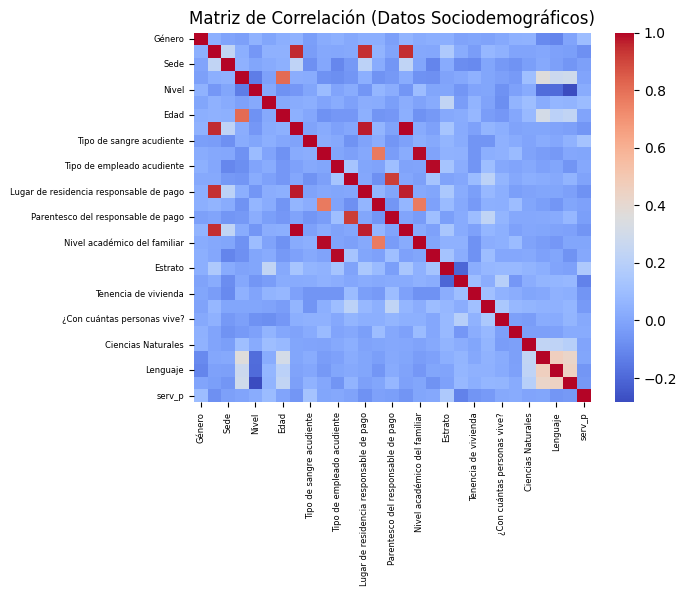

In [ ]:
# Correlación Spearman
df_corr_p2 = df_clean_p2.iloc[:,1:31].corr(method='kendall')


# Plot Matriz Correlación 

sns.heatmap(df_corr_p2, cmap='coolwarm')
plt.title('Matriz de Correlación (Datos Sociodemográficos)')

plt.xticks(fontsize=6)
plt.yticks(fontsize=6)

plt.show()


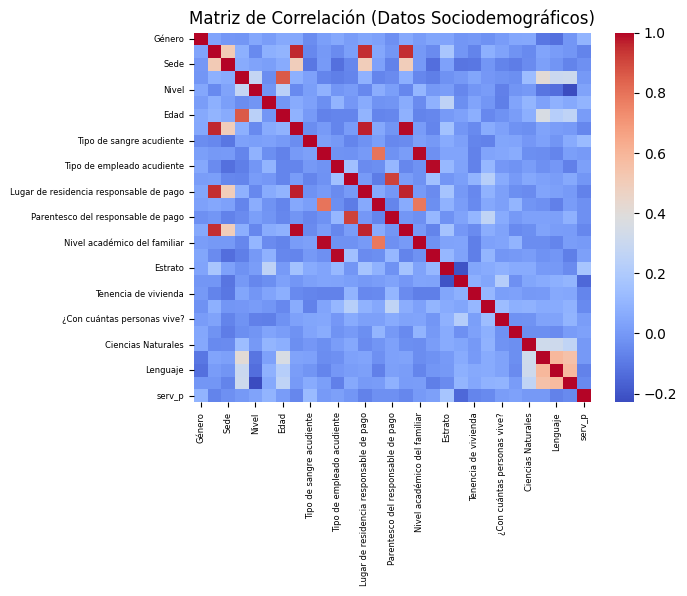

In [ ]:
# Correlación Pearson

df_corr_p2 = df_clean_p2.iloc[:,1:31].corr()


# Plot Matriz Correlación 

sns.heatmap(df_corr_p2, cmap='coolwarm')
plt.title('Matriz de Correlación (Datos Sociodemográficos)')

plt.xticks(fontsize=6)
plt.yticks(fontsize=6)

plt.show()

In [ ]:
# Correlación múltiple de variables sociodemográficas

# Matriz de covarianzas
S_p2 = df_clean_p2.iloc[:,1:31].cov().values

# Matriz Inversa de covarianzas
S_inv_p2 = np.linalg.inv(S_p2)
S_inv_p2.round(2)

Vector_Corre_Multiples = 1 - 1/ (np.diag(S_p2) * np.diag(S_inv_p2))
Vector_Corre_Multiples.round(4)

array([0.0895, 0.93  , 0.3291, 0.7776, 0.2489, 0.1263, 0.7546, 0.9996,
       0.0759, 0.9999, 0.9998, 0.8464, 0.952 , 0.6558, 0.846 , 0.9996,
       0.9999, 0.9998, 0.221 , 0.1585, 0.1   , 0.1611, 0.1209, 0.1173,
       0.1858, 0.4925, 0.4841, 0.487 , 0.1028])

In [ ]:
df_final_p2 = df_clean_p2.drop([df_clean_p2.columns[10], df_clean_p2.columns[18]], axis=1)

##Target: Vector distancias al resultado ideal


In [ ]:
# Separar X y Y
X = df_final_p2.iloc[:, 1:-5]
X['serv_p'] = df_final_p2['serv_p']
X.reset_index(drop=True, inplace=True)

Y = df_final_p2.iloc[:, -5:-1]
Y.reset_index(drop=True, inplace=True)

In [ ]:
# Vector distancia de los datos al ideal
# Nota: El resultado ideal se toma como el vector [1, 1, 1, 1], que corresponde a un score perfecto en las 4 materias

y_euclidea_ideal = np.array([distance.euclidean(Y.iloc[d, :], np.array([1,1,1,1])) for d in range(len(Y))])

(array([  3.,  31.,  53.,  75., 106.,  86.,  89.,  37.,  23.,   8.]),
 array([0.2       , 0.37519221, 0.55038443, 0.72557664, 0.90076885,
        1.07596106, 1.25115328, 1.42634549, 1.6015377 , 1.77672992,
        1.95192213]),
 <BarContainer object of 10 artists>)

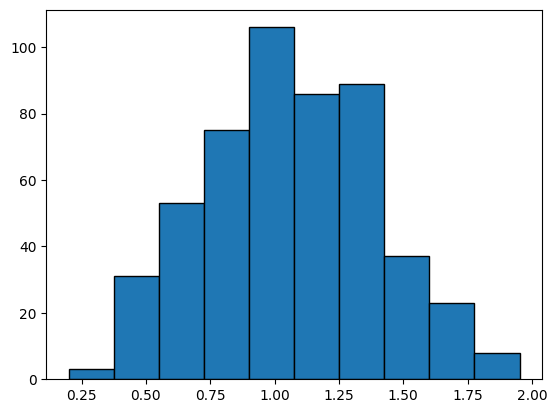

In [ ]:
# Plot de distancias al ideal 

## Nota: entre menor distancia, mejor el resultado!!

plt.hist(y_euclidea_ideal, bins=10, edgecolor='black')

In [ ]:
# Definición de percentiles para indexar 

perc_25 = np.percentile(y_euclidea_ideal, 25)
perc_50 = np.percentile(y_euclidea_ideal, 50)
perc_75 = np.percentile(y_euclidea_ideal, 75)


In [ ]:
# Definición de Corte Académico (Indices)

corte_sup = Y[y_euclidea_ideal <= perc_25].index
corte_medsup = Y[(perc_25 < y_euclidea_ideal) & (y_euclidea_ideal <= perc_50)].index
corte_medinf = Y[(perc_50 < y_euclidea_ideal) & (y_euclidea_ideal <= perc_75)].index
corte_inf = Y[perc_75 < y_euclidea_ideal].index


In [ ]:
# Vista de resultados corte inferior

Y.iloc[corte_inf,:].head(5)

,Ciencias Naturales,Competencias Ciudadanas,Lenguaje,Matematicas
1,0.20,0.10,0.60,0.40
22,0.40,0.00,0.40,0.30
32,0.30,0.20,0.30,0.50
34,0.50,0.20,0.30,0.10
36,0.10,0.00,0.10,0.20


In [ ]:
# Vista de resultados corte superior

Y.iloc[corte_sup,:].head(5)

,Ciencias Naturales,Competencias Ciudadanas,Lenguaje,Matematicas
3,0.80,0.60,0.70,0.50
5,0.80,0.80,0.50,0.50
9,0.40,0.60,0.80,0.70
10,0.60,0.50,0.70,0.60
11,0.70,0.80,0.70,0.50


In [ ]:
# Matriz con vector target (Creación Vector Y = [])

matriz_materias_classified = Y.copy()
matriz_materias_classified['Y'] = ""

In [ ]:
# Poblar vector target

matriz_materias_classified.loc[corte_sup, 'Y'] = 3 # Corte Superior
matriz_materias_classified.loc[corte_medsup, 'Y'] = 2 # Corte Medio-Superior
matriz_materias_classified.loc[corte_medinf, 'Y'] = 1 # Corte Medio-Inferior
matriz_materias_classified.loc[corte_inf, 'Y'] = 0 # Corte Inferior

In [ ]:
# Matriz con vector target dado por distancia al ideal

matriz_materias_classified

,Ciencias Naturales,Competencias Ciudadanas,Lenguaje,Matematicas,Y
0,0.50,0.40,0.80,0.30,1
1,0.20,0.10,0.60,0.40,0
2,0.30,0.60,0.70,0.80,2
3,0.80,0.60,0.70,0.50,3
4,0.50,0.40,0.70,0.60,2
...,...,...,...,...,...
506,1.00,0.70,0.70,0.80,3
507,0.10,0.20,0.00,0.00,0
508,0.40,0.40,0.40,0.50,1
509,0.90,0.80,0.40,0.60,3


In [ ]:
# Vector target de distancias euclidea ideales

Y_dist_ideal = matriz_materias_classified['Y']

In [ ]:
# Correlación múltiple de variables con target ['Y']

# Creación de matriz con atributos y target

matriz_corr_target = X.copy()

matriz_corr_target['clasificacion'] = Y_dist_ideal.astype(int)

# Matriz de covarianzas

S_ = matriz_corr_target.cov().values

# Matriz Inversa de covarianzas
S_inv_ = np.linalg.inv(S_)
S_inv_.round(2)

Vector_Corre_Multiples_target = 1 - 1/ (np.diag(S_) * np.diag(S_inv_))
Vector_Corre_Multiples_target.round(4)

array([0.0531, 0.9296, 0.3249, 0.7696, 0.1999, 0.1053, 0.7504, 0.9914,
       0.0601, 0.0976, 0.8454, 0.9517, 0.6532, 0.8442, 0.9891, 0.6452,
       0.2116, 0.1566, 0.0818, 0.1554, 0.1164, 0.1081, 0.0964, 0.2471])

In [ ]:
correlacion_multiple = dict(zip(matriz_corr_target.columns, Vector_Corre_Multiples_target ))

In [ ]:
Y_dist_ideal.astype(int)

0      1
1      0
2      2
3      3
4      2
      ..
506    3
507    0
508    1
509    3
510    3
Name: Y, Length: 511, dtype: int64

##Target: K-means

In [ ]:
# Matriz materias

matriz_k_means = Y.copy()

In [ ]:
# Modelo K-means

from sklearn.cluster import KMeans
import numpy as np

km = KMeans (n_clusters=3, random_state=13)
y_predicted = km.fit_predict(matriz_k_means[['Ciencias Naturales', 'Competencias Ciudadanas', 'Lenguaje',
       'Matematicas']])


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
# Creación de columna `cluster` para aislar los resultados

matriz_k_means['Y'] = y_predicted

In [ ]:
# Descripción estadísticas de clustering

print(matriz_k_means[matriz_k_means['Y'] == 0 ].iloc[:,:-1].describe())
print()
print(matriz_k_means[matriz_k_means['Y'] == 1 ].iloc[:,:-1].describe())
print()
print(matriz_k_means[matriz_k_means['Y'] == 2 ].iloc[:,:-1].describe())
print()

### Se percibe que los clusters están distribuidos de la siguiente manera: 
## Cluster 0: Estudiantes de bajo rendimiento
## Cluster 1: Estudiantes de alto rendimiento
## Cluster 2: Estudiantes de mediano rendimiento 


       Ciencias Naturales  Competencias Ciudadanas  Lenguaje  Matematicas
count              201.00                   201.00    201.00       201.00
mean                 0.50                     0.44      0.58         0.51
std                  0.20                     0.16      0.15         0.15
min                  0.10                     0.10      0.20         0.10
25%                  0.40                     0.30      0.50         0.40
50%                  0.50                     0.40      0.60         0.50
75%                  0.60                     0.60      0.70         0.60
max                  1.00                     0.90      1.00         0.90

       Ciencias Naturales  Competencias Ciudadanas  Lenguaje  Matematicas
count              167.00                   167.00    167.00       167.00
mean                 0.32                     0.23      0.30         0.34
std                  0.18                     0.14      0.16         0.17
min                  0.00            

In [ ]:
# Idx de diferentes clusters

idx_0 = matriz_k_means[matriz_k_means['Y'] == 0 ].iloc[:,:-1].index # bajo rendimiento
idx_1 = matriz_k_means[matriz_k_means['Y'] == 1 ].iloc[:,:-1].index # alto rendimiento
idx_2 = matriz_k_means[matriz_k_means['Y'] == 2 ].iloc[:,:-1].index # mediano rendimiento

In [ ]:
# Conteo de estudiantes por cluster

bajo_rend = len(idx_0)
alto_rend = len(idx_1)
med_rend = len(idx_2)

print(f'Estudiantes de bajo rendimiento: {bajo_rend}')
print()
print(f'Estudiantes de alto rendimiento: {alto_rend}')
print()
print(f'Estudiantes de mediano rendimiento: {med_rend}')

Estudiantes de bajo rendimiento: 201

Estudiantes de alto rendimiento: 167

Estudiantes de mediano rendimiento: 143


In [ ]:
# Correlación múltiple de variables con target ['Y']

# Creación de matriz con atributos y target

X_mod2 = X.copy()

Y = y_predicted

# Matriz de covarianzas

S_kmeans = X_mod2.cov().values

# Matriz Inversa de covarianzas
S_inv_kmeans = np.linalg.inv(S_kmeans)
S_inv_kmeans.round(2)

Vector_Multiples_kmeans = 1 - 1/ (np.diag(S_kmeans) * np.diag(S_inv_kmeans))
Vector_Multiples_kmeans.round(4)

array([0.051 , 0.9295, 0.3246, 0.7542, 0.1226, 0.0951, 0.7504, 0.9914,
       0.0598, 0.0965, 0.8448, 0.9517, 0.653 , 0.8441, 0.9891, 0.6452,
       0.21  , 0.1483, 0.0813, 0.1463, 0.1132, 0.1078, 0.0959])

##Modelos

### Model Decision Tree Classifier

#### Modelos: Decision Tree Classifier(K-means)

In [ ]:
# Modelo de Classificador Decision Tree Classifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

In [ ]:
# Splitting the data

X_trainset, X_testset, y_trainset, y_testset = train_test_split(X_mod2, Y.astype(int), test_size=0.3, random_state=3)

tree_class = DecisionTreeClassifier(random_state=3)

tree_class.fit(X_trainset, y_trainset)


DecisionTreeClassifier(random_state=3)

In [ ]:
# Precisión

acc = np.mean(tree_class.predict(X_testset) == y_testset).round(4)

print(f'La precisión del modelo Tree Classifier es de {acc * 100} %')

La precisión del modelo Tree Classifier es de 38.96 %


#### Modelos: Decision Tree Classifier(Distancia Euclidia)

In [ ]:
# Splitting the data

X_trainset, X_testset, y_trainset, y_testset = train_test_split(X_mod2, Y_dist_ideal.astype(int), test_size=0.3, random_state=3)

tree_class = DecisionTreeClassifier(random_state=3)

tree_class.fit(X_trainset, y_trainset)

DecisionTreeClassifier(random_state=3)

In [ ]:
# Precisión

acc = np.mean(tree_class.predict(X_testset) == y_testset).round(4)

print(f'La precisión del modelo Tree Classifier es de {acc * 100} %')

La precisión del modelo Tree Classifier es de 33.12 %


### Model Random Forest

#### Modelos: Random Forest (K-means)


In [ ]:
# Modelo de Classificador Random Forest

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [ ]:
# Splitting the data

X_trainset, X_testset, y_trainset, y_testset = train_test_split(X_mod2, Y.astype(int), test_size=0.3, random_state=3)

forest = RandomForestClassifier(criterion='gini', n_estimators=100)

forest.fit(X_trainset, y_trainset)


RandomForestClassifier()

In [ ]:
# Precisión

acc = np.mean(forest.predict(X_testset) == y_testset).round(4)

print(f'La precisión del modelo Random Forest es de {acc * 100} %')

La precisión del modelo Random Forest es de 48.05 %


#### Modelos: Random Forest (Distancia Euclidea)

In [ ]:
# Modelo de Classificador Random Forest

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [ ]:
# Splitting the data

X_trainset, X_testset, y_trainset, y_testset = train_test_split(X_mod2, Y_dist_ideal.astype(int), test_size=0.3, random_state=3)

forest = RandomForestClassifier(criterion='gini', n_estimators=100)

forest.fit(X_trainset, y_trainset)


RandomForestClassifier()

In [ ]:
# Precisión

acc = np.mean(forest.predict(X_testset) == y_testset).round(4)

print(f'La precisión del modelo Random Forest es de {acc * 100} %')

La precisión del modelo Random Forest es de 35.06 %


### Model Support Vector Machine


#### Modelos: SVM (Distancia Euclidea)

In [ ]:
from sklearn.svm import SVC
X_trainset, X_testset, y_trainset, y_testset = train_test_split(X_mod2, Y_dist_ideal.astype(int), test_size=0.3, random_state=3)
clf = SVC(kernel='linear')
clf.fit(X_trainset, y_trainset)
predictions = clf.predict(X_testset)



In [ ]:
# Precisión
acc=metrics.accuracy_score(y_testset, tree_class.predict(X_testset))
print(f'La precisión del modelo Tree Classifier es de {acc * 100} %')

La precisión del modelo Tree Classifier es de 33.116883116883116 %


#### Modelos: SVM (K-means)

In [ ]:
from sklearn.svm import SVC
X_trainset, X_testset, y_trainset, y_testset = train_test_split(X_mod2, Y.astype(int), test_size=0.3, random_state=3)
clf = SVC(kernel='linear')
clf.fit(X_trainset, y_trainset)
predictions = clf.predict(X_testset)



In [ ]:
# Precisión
acc=metrics.accuracy_score(y_testset, tree_class.predict(X_testset))
print(f'La precisión del modelo Tree Classifier es de {acc * 100} %')

La precisión del modelo Tree Classifier es de 32.467532467532465 %


# Método 3: Depuración de variables por medio de correlación múltiple

## Preprocesamiento

In [ ]:
# DataFrame Sociodemográfico Estudiantes

## Sin vinculación a Colab:
# estudiantes = pd.pd.read_excel('/content/estudiantes_anonimizados.xlsx')

estudiantes = pd.read_excel('/content/gdrive/MyDrive/Colab Notebooks/PROYECTO INTEGRADOR/data/estudiantes_anonimizados.xlsx')
estudiantes_p3=estudiantes.drop('Grado', axis=1)

In [ ]:
# DataFrame Linea Base Académica

## Sin vinculación a Colab:
# linea_base = pd.read_excel('/content/linea_base_2023_1_anonimizada.xlsx')

linea_base = pd.read_excel('/content/gdrive/MyDrive/Colab Notebooks/PROYECTO INTEGRADOR/data/linea_base_2023_1_anonimizada.xlsx')

In [ ]:
# Selección de Variables de Resultados en DataFrame `linea_base`
# Nota: Esta depuración se mantiene en ambos métodos por ser las variables de mayor calidad. 

resultadosPruebas_p3 = linea_base[['estudiante','Grado','Ciencias Naturales',
       'Competencias Ciudadanas', 'Lenguaje', 'Matematicas']].dropna()
resultadosPruebas_p3.reset_index(drop=True, inplace=True)

In [ ]:
# Se crea un dataframe unificado para rastrear las variables de menor calidad

df_merged_p3 = estudiantes_p3.merge(resultadosPruebas_p3, how = 'inner', left_on='id_estudiante', right_on='estudiante')

In [ ]:
# Conteo de NaNs por fila

df_merged_p3['Conteo_NaNs'] = ""

# Obtener los IDs únicos de los estudiantes en una lista
ids_unicos = df_merged_p3['id_estudiante'].unique().tolist()

# Iterar sobre cada ID único
for i in ids_unicos:
    # Obtener los índices de las filas correspondientes a ese ID
    lista_indices_filas = df_merged_p3[df_merged_p3['id_estudiante'] == i].index.tolist()
    
    # Iterar sobre cada índice de fila
    for idx in lista_indices_filas:
        # Calcular la suma de valores nulos en la fila actual
        suma_nulos = df_merged_p3.iloc[idx, :].isnull().sum()
        
        # Asignar la suma de nulos a la columna 'conteo_nulos' en la fila actual
        df_merged_p3.at[idx, 'Conteo_NaNs'] = suma_nulos

In [ ]:
df_merged_p3 = df_merged_p3.sort_values(by=['id_estudiante', 'Conteo_NaNs'], ignore_index=True)

df_merged_p3['conteo'] = df_merged_p3.groupby(['id_estudiante']).cumcount()

df_merged_p3 = df_merged_p3.drop_duplicates('id_estudiante', ignore_index=True)

In [ ]:
df_merged_p3['conteo'].unique()

array([0])

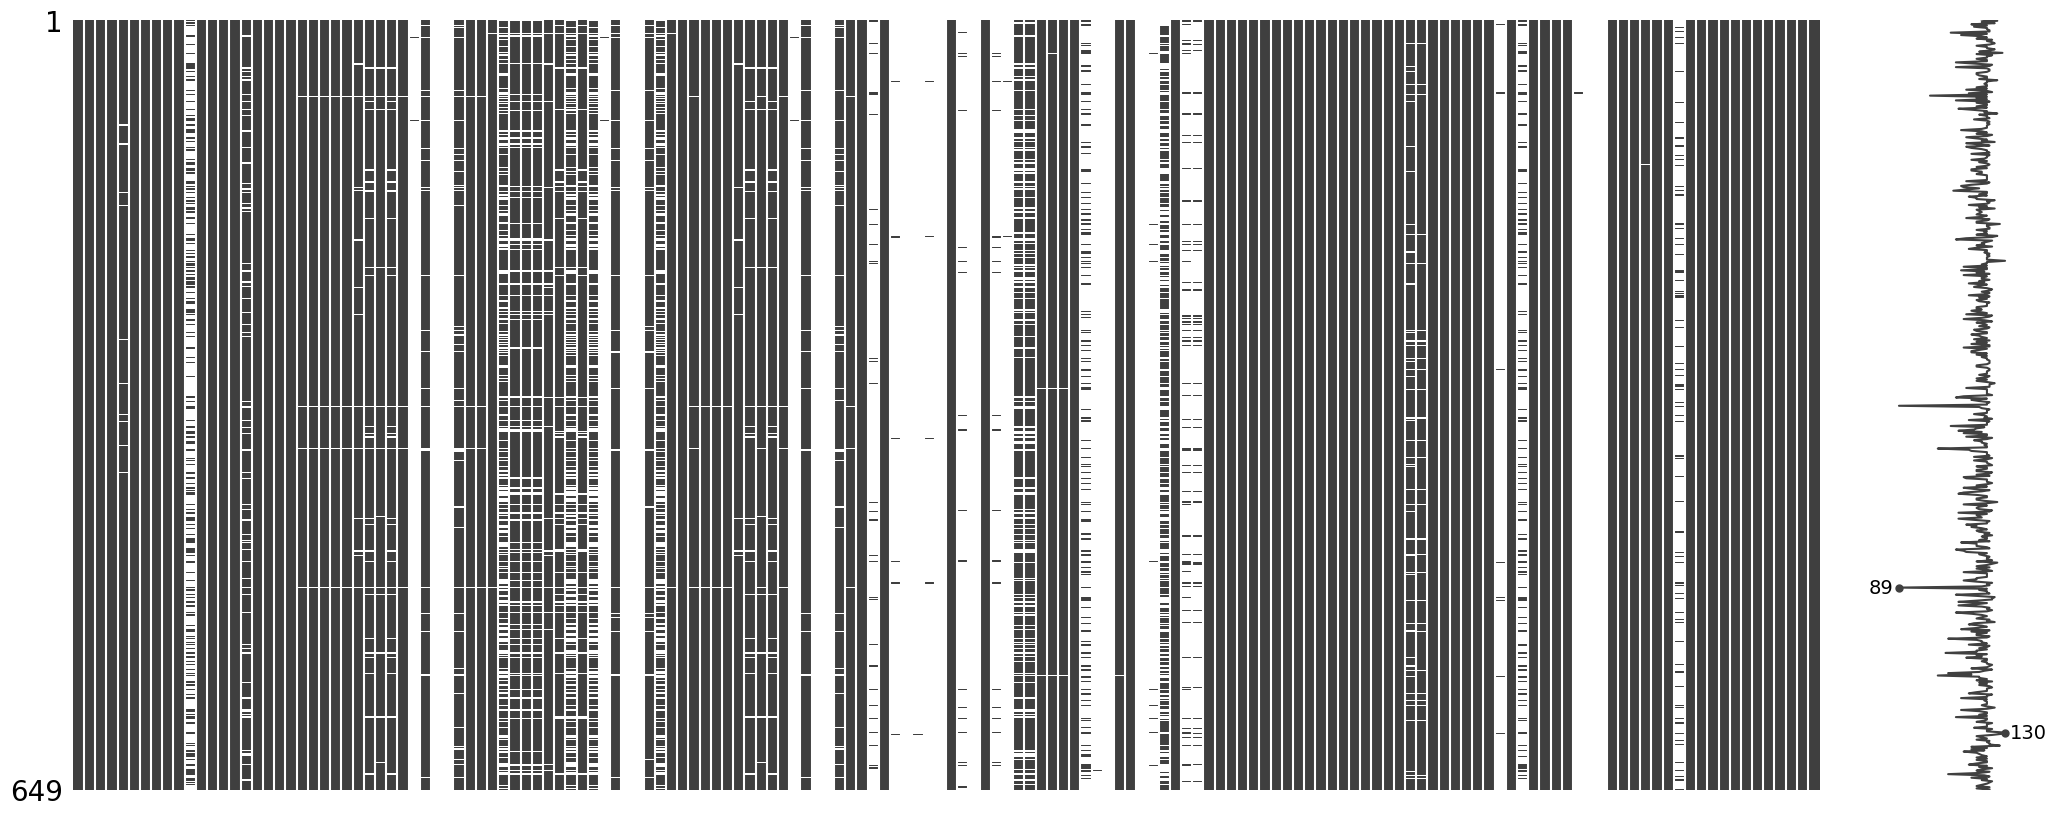

<Figure size 1500x900 with 0 Axes>

In [ ]:
msno.matrix(df_merged_p3)
plt.figure(figsize = (15,9))
plt.show()

In [ ]:
# Eliminamos columnas con alto porcentaje de valores nulos
columnas_eliminar = []
columnas = list(df_merged_p3.columns)
columa_porcentaje = {}

for i in range(len(columnas)):
  porcentaje_nulos = df_merged_p3.iloc[:, i].isnull().sum() / len(df_merged_p3)
  columa_porcentaje[columnas[i]] =  porcentaje_nulos
  
  if porcentaje_nulos >= 0.08:
    columnas_eliminar.append(columnas[i])

In [ ]:
df_filt_nulls_p3 = df_merged_p3.drop(columnas_eliminar, axis=1)

In [ ]:
#eliminar registros con NA y las personas del grado 'Tercero', 'Cuarto' y  'Décimo - Undécimo' 
df_sinnap3=df_filt_nulls_p3.copy()
df_sinnap3 = df_sinnap3.drop(df_sinnap3[df_sinnap3['Grado'] == 'Tercero'].index)
df_sinnap3 = df_sinnap3.drop(df_sinnap3[df_sinnap3['Grado'] == 'Cuarto'].index)
df_sinnap3 = df_sinnap3.drop(df_sinnap3[df_sinnap3['Grado'] == 'Décimo - Undécimo'].index)
df_sinnap3=df_sinnap3.dropna(axis=0)
df_sinnap3.shape

(501, 112)

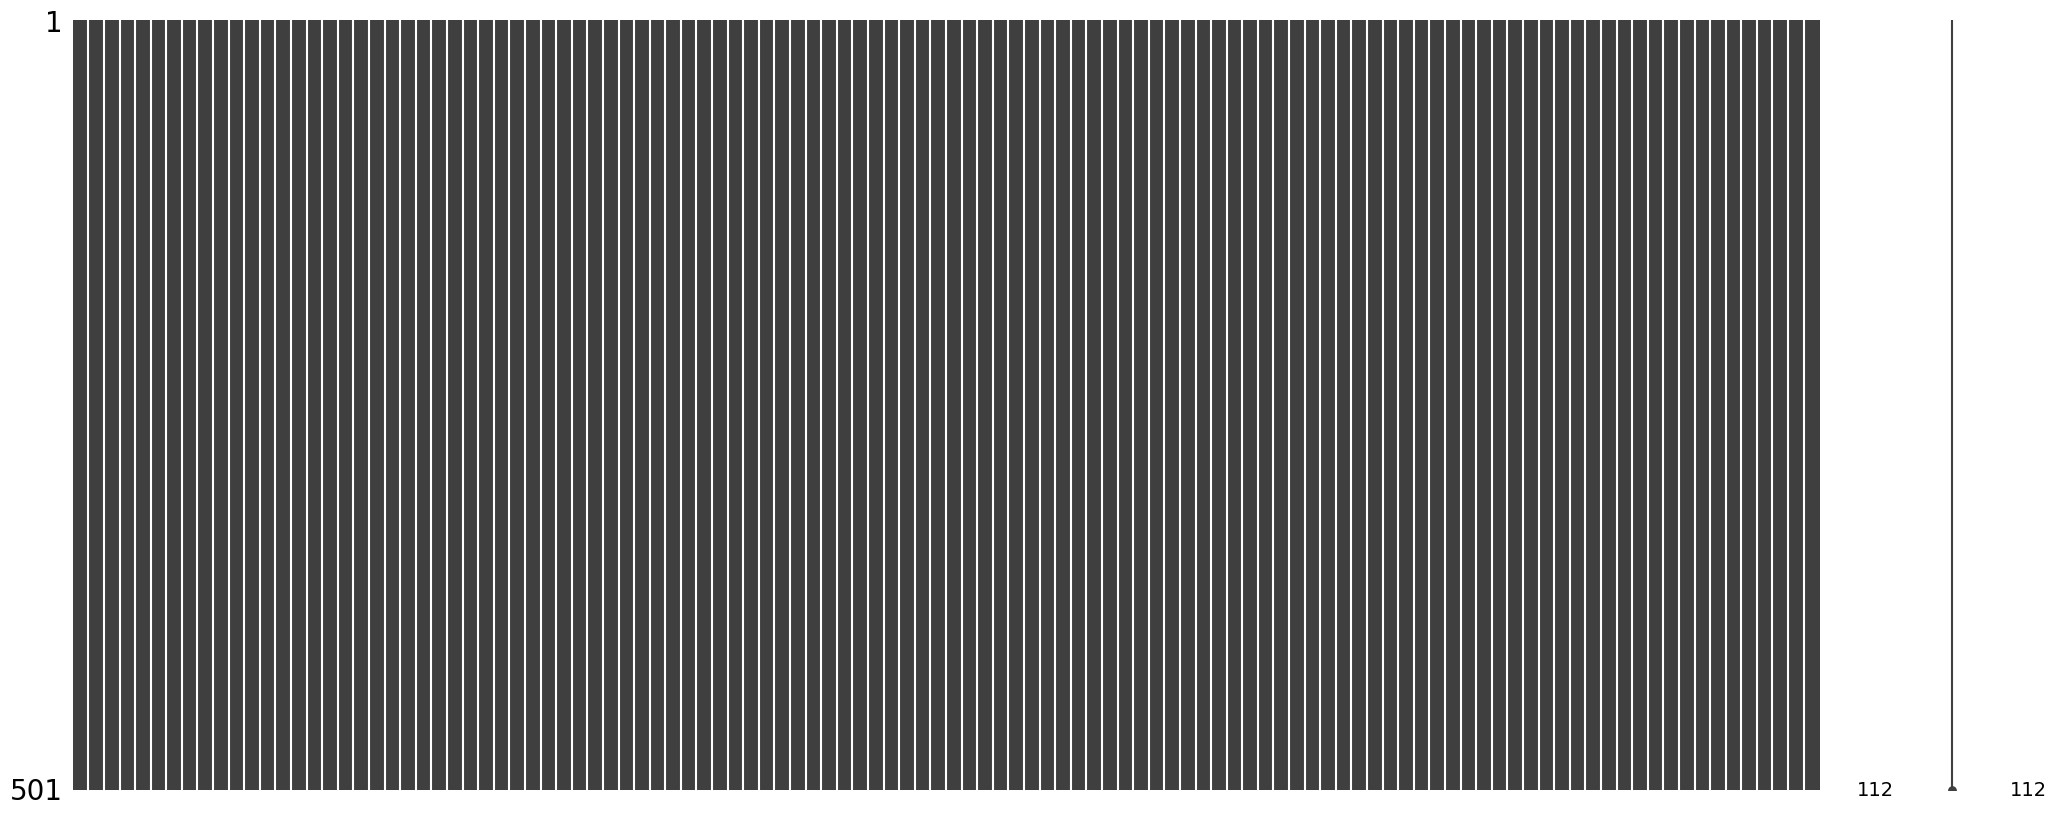

<Figure size 1500x900 with 0 Axes>

In [ ]:
msno.matrix(df_sinnap3)
plt.figure(figsize = (15,9))
plt.show()

In [ ]:
# Conversión de variables de acudientes a variables numéricas
df_encod_p3=df_sinnap3.copy()
df_encod_p3 = df_encod_p3.drop(['Código de matrícula', 'Conteo_NaNs','estudiante','conteo'], axis=1)
df_encod_p3.iloc[:,[13]+[14]+[16]+[29]+[50]+[63]+list(range(67,69))+list(range(70,72))+[75]+list(range(97,98))+list(range(103,108))].columns

Index(['Periodo', 'Nivel', 'Edad',
       '¿Con qué frecuencia ha cambiado de domicilio en el último año?',
       '¿Con qué frecuencia ha cambiado de domicilio en el último año? (2)',
       'Estrato', '¿Cuenta con servicio de alcantarillado?',
       '¿Cuenta con servicio de gas?', '¿Cuenta con servicio de internet?',
       '¿Cuenta con servicio de energía?', '¿Con cuántas personas vive?',
       'Abandonos temporales (año lectivo actual)', 'Grado',
       'Ciencias Naturales', 'Competencias Ciudadanas', 'Lenguaje',
       'Matematicas'],
      dtype='object')

In [ ]:
diccionario={}
for i, j in enumerate(df_encod_p3.columns):
  diccionario[j]=i

In [ ]:

# Conversión de variables de acudientes a variables numéricas
df_encod_p3=df_sinnap3.copy()
df_encod_p3 = df_encod_p3.drop(['Código de matrícula', 'Conteo_NaNs','estudiante','conteo'], axis=1)
# Selección de variables
df_encod_p3.columns.get_loc('Beneficiario de padre cabeza de familia')

76

## Encoding

In [ ]:
# Conversión de variables de acudientes a variables numéricas
df_encod_p3=df_sinnap3.copy()
df_encod_p3 = df_encod_p3.drop(['Código de matrícula', 'Conteo_NaNs','estudiante','conteo'], axis=1)
# Selección de variables

columnas_encp3=df_encod_p3.iloc[:,list(range(1,13))+[14]+list(range(15,16))+list(range(17,29))+list(range(30,50))+list(range(51,63))+list(range(64,66))+[69]+list(range(72,75))+[76]+list(range(77,97))+[98]+list(range(99,103))].columns

# Categorizador
categorizador = preprocessing.LabelEncoder()

for c in columnas_encp3:
  categorizador.fit(df_encod_p3[c])
  df_encod_p3[c] = categorizador.transform(df_encod_p3[c]) 

In [ ]:
#crear variable conjunta por servicios públicos
servicios_publicos_p3 = df_filt_nulls_p3[['¿Cuenta con servicio de agua?',
                                          '¿Cuenta con servicio de alcantarillado?','¿Cuenta con servicio de gas?','¿Cuenta con servicio de internet?','¿Cuenta con servicio de energía?']]

sp3=servicios_publicos_p3.columns
binary_mapping = {'Sí': 1, 'No': 0}
for col in sp3:
  servicios_publicos_p3[col] = servicios_publicos_p3[col].map(binary_mapping)

servicios_publicos_p3['servicios_pub'] = 0

for i in range(len(servicios_publicos_p3)):
  if servicios_publicos_p3.iloc[i, :].sum() == 5:
    servicios_publicos_p3.at[i, 'servicios_pub'] = 1
  
servicios_publicos_p3=servicios_publicos_p3.drop(servicios_publicos_p3.iloc[:,0:5], axis=1)
servicios_publicos_p3.head()
df_encod_p3['serv_p']=servicios_publicos_p3
df_encod_p3=df_encod_p3.drop(['¿Cuenta con servicio de agua?',
                                          '¿Cuenta con servicio de alcantarillado?','¿Cuenta con servicio de gas?','¿Cuenta con servicio de internet?','¿Cuenta con servicio de energía?'],axis=1)

<ipython-input-1640-12db21a96800>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  servicios_publicos_p3[col] = servicios_publicos_p3[col].map(binary_mapping)
<ipython-input-1640-12db21a96800>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  servicios_publicos_p3[col] = servicios_publicos_p3[col].map(binary_mapping)
<ipython-input-1640-12db21a96800>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

In [ ]:
# Conversión de variable `Grado` a numéricos

grade_mapping = {'Quinto': 5, 'Sexto': 6, 'Septimo':7, 'Octavo':8, 'Noveno':9,'InspiraTec Noveno':9,'Decimo':10, 'decimo':10, 'InspiraTec Decimo':10, 'Nuevas Oportunidades 10-11':11 }
df_encod_p3['Grado'] = df_encod_p3['Grado'].map(grade_mapping)
grade_mapping2 = {'No ha cambiado':0,'Entre 1 y 2 veces':2,'Entre 3 y 4 veces':4}
df_encod_p3['¿Con qué frecuencia ha cambiado de domicilio en el último año?'] = df_encod_p3['¿Con qué frecuencia ha cambiado de domicilio en el último año?'].map(grade_mapping2)
df_encod_p3['¿Con qué frecuencia ha cambiado de domicilio en el último año? (2)'] = df_encod_p3['¿Con qué frecuencia ha cambiado de domicilio en el último año? (2)'].map(grade_mapping2)


#conversión a variable int
df_encod_p3['Estrato'] = df_encod_p3['Estrato'].astype(int)
df_encod_p3['Grado'] = df_encod_p3['Grado'].astype(int)
df_encod_p3['Edad'] = df_encod_p3['Edad'].astype(int)
df_encod_p3['¿Con qué frecuencia ha cambiado de domicilio en el último año?'] = df_encod_p3['¿Con qué frecuencia ha cambiado de domicilio en el último año?'].astype(int)
df_encod_p3['Periodo'] = df_encod_p3['Periodo'].astype(int)
df_encod_p3['¿Con cuántas personas vive?'] = df_encod_p3['¿Con cuántas personas vive?'].replace('Más de 10', 10)
df_encod_p3['¿Con cuántas personas vive?'] = df_encod_p3['¿Con cuántas personas vive?'].astype(int)

In [ ]:
#Eliminar columnas en la cual sus registros es el mismo valor
num_valores_unicos=pd.DataFrame(df_encod_p3.nunique())
elim_valores = list(num_valores_unicos[num_valores_unicos[0] == 1].index)
df_encod_p3 = df_encod_p3.drop(columns=elim_valores)

## Estadística descriptivas

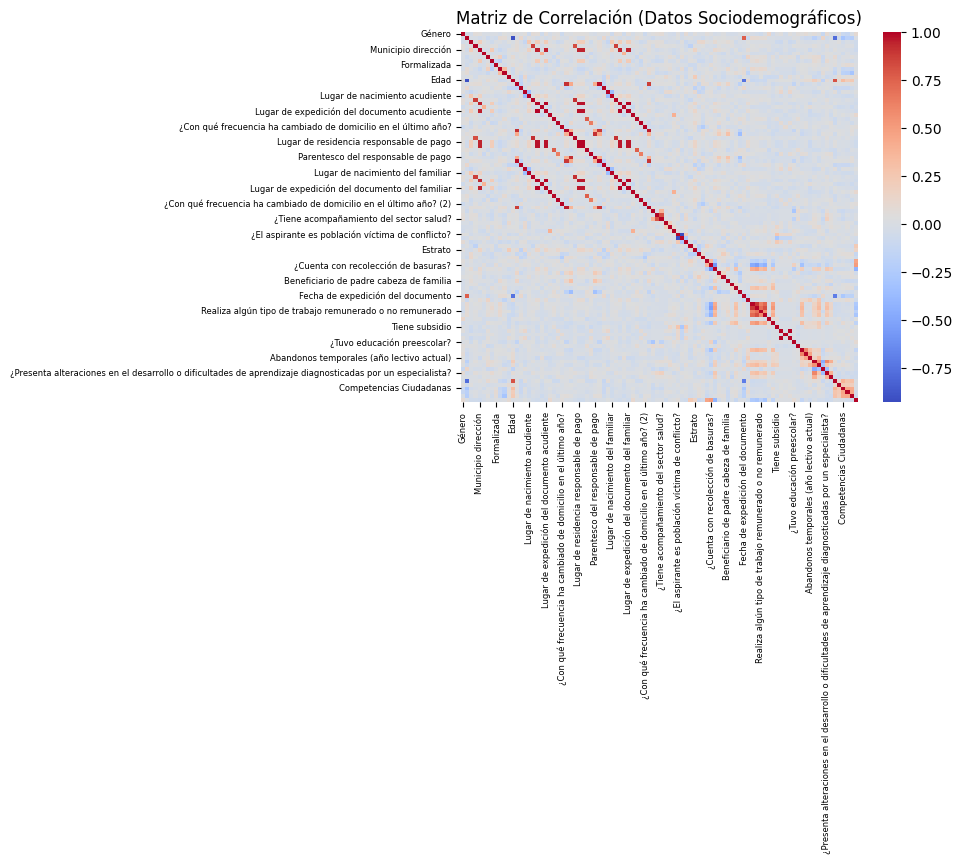

In [ ]:
# Correlación Spearman
df_corr_p3 = df_encod_p3.iloc[:,1:].corr(method='kendall')


# Plot Matriz Correlación 

sns.heatmap(df_corr_p3, cmap='coolwarm')
plt.title('Matriz de Correlación (Datos Sociodemográficos)')

plt.xticks(fontsize=6)
plt.yticks(fontsize=6)

plt.show()

In [ ]:
#eliminar información del familiar y responsable de pago para quedarse con el acudiente
df_norep=df_encod_p3.copy()
elim_familia=[i for i in df_corr_p3.columns if i.endswith('familiar')]
df_norep=df_norep.drop(elim_familia, axis=1)
elim_resppago=[i for i in df_corr_p3.columns if i.endswith('responsable de pago')]
df_norep=df_norep.drop(elim_resppago, axis=1)

In [ ]:
df_norep=df_norep.drop('¿Con qué frecuencia ha cambiado de domicilio en el último año? (2)', axis=1)


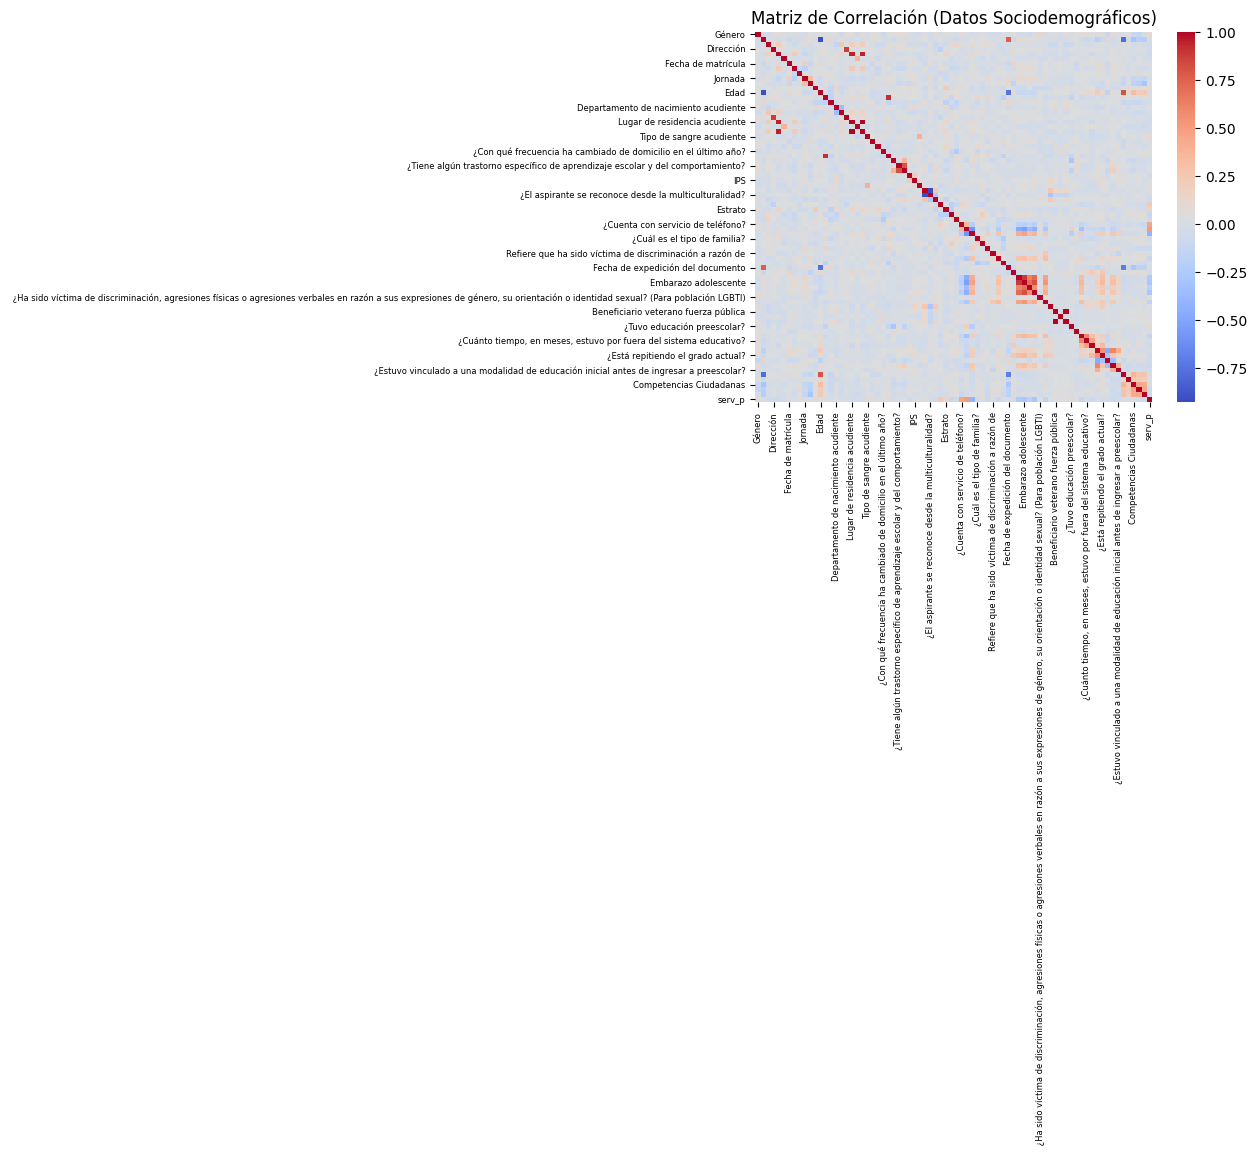

In [ ]:
# Correlación Spearman
df_corr_p3norep = df_norep.iloc[:,1:].corr(method='kendall')


# Plot Matriz Correlación 

sns.heatmap(df_corr_p3norep, cmap='coolwarm')
plt.title('Matriz de Correlación (Datos Sociodemográficos)')

plt.xticks(fontsize=6)
plt.yticks(fontsize=6)

plt.show()

In [ ]:
lista=[]
filas=list(df_corr_p3norep.index)
columnas=list(df_corr_p3norep.columns)

for i in range(len(df_corr_p3norep)):
  for j in range(len(df_corr_p3norep)):
    if i!=j:
      valid_corr=abs(df_corr_p3norep.iloc[i,j])
      if valid_corr>=0.65:
       lista.append((filas[i],columnas[j],valid_corr))
lista

[('Fecha de nacimiento', 'Edad', 0.9116990630519614),
 ('Fecha de nacimiento',
  'Fecha de expedición del documento',
  0.761565417270813),
 ('Fecha de nacimiento', 'Grado', 0.7829318741962666),
 ('Dirección', 'Dirección acudiente', 0.8751102942688853),
 ('Municipio dirección', 'Lugar de residencia acudiente', 0.9490852398252023),
 ('Municipio dirección',
  'Lugar de expedición del documento acudiente',
  0.9490852398252023),
 ('Edad', 'Fecha de nacimiento', 0.9116990630519614),
 ('Edad', 'Fecha de expedición del documento', 0.7500525579771515),
 ('Edad', 'Grado', 0.807919854170673),
 ('Sexo acudiente', 'Parentesco del acudiente', 0.9147832423330174),
 ('Dirección acudiente', 'Dirección', 0.8751102942688853),
 ('Lugar de residencia acudiente', 'Municipio dirección', 0.9490852398252023),
 ('Lugar de residencia acudiente',
  'Lugar de expedición del documento acudiente',
  0.9999999999999998),
 ('Lugar de expedición del documento acudiente',
  'Municipio dirección',
  0.9490852398252023)

In [ ]:
# Conteo de valores con alta correlación
val_uniq=[]
for l in range(len(lista)):
  b1=lista[l][0]
  b2=lista[l][1]
  if b1 not in val_uniq:
    val_uniq.append(b1)
  if b2 not in val_uniq:
    val_uniq.append(b2)

dic_uniq={}
for k in val_uniq:
  contador=0
  for l in range(len(lista)):
    b1=lista[l][0] 
    b2=lista[l][1]
    if b1 == k or b2 == k:
     contador += 1
  dic_uniq[k] = contador
dic_uniq

{'Fecha de nacimiento': 6,
 'Edad': 6,
 'Fecha de expedición del documento': 6,
 'Grado': 6,
 'Dirección': 2,
 'Dirección acudiente': 2,
 'Municipio dirección': 4,
 'Lugar de residencia acudiente': 4,
 'Lugar de expedición del documento acudiente': 4,
 'Sexo acudiente': 2,
 'Parentesco del acudiente': 2,
 '¿Tiene algún trastorno específico de aprendizaje escolar y del comportamiento?': 2,
 '¿Tiene acompañamiento del sector salud?': 2,
 '¿El aspirante es población víctima de conflicto?': 2,
 '¿El aspirante se reconoce desde la multiculturalidad?': 2,
 'El estudiante vive solo': 4,
 'Embarazo adolescente': 6,
 'Maternidad o paternidad a temprana edad': 4,
 'Realiza algún tipo de trabajo remunerado o no remunerado': 2,
 'Beneficiario veterano fuerza pública': 2,
 'Proviene de otro municipio': 2}

In [ ]:
df_fin_n=df_norep.copy()
df_fin_n=df_fin_n.drop('Fecha de nacimiento', axis=1)
df_fin_n=df_fin_n.drop('Fecha de expedición del documento', axis=1)
df_fin_n=df_fin_n.drop('Embarazo adolescente', axis=1)
df_fin_n=df_fin_n.drop('Lugar de residencia acudiente', axis=1)
df_fin_n=df_fin_n.drop('Lugar de expedición del documento acudiente', axis=1)

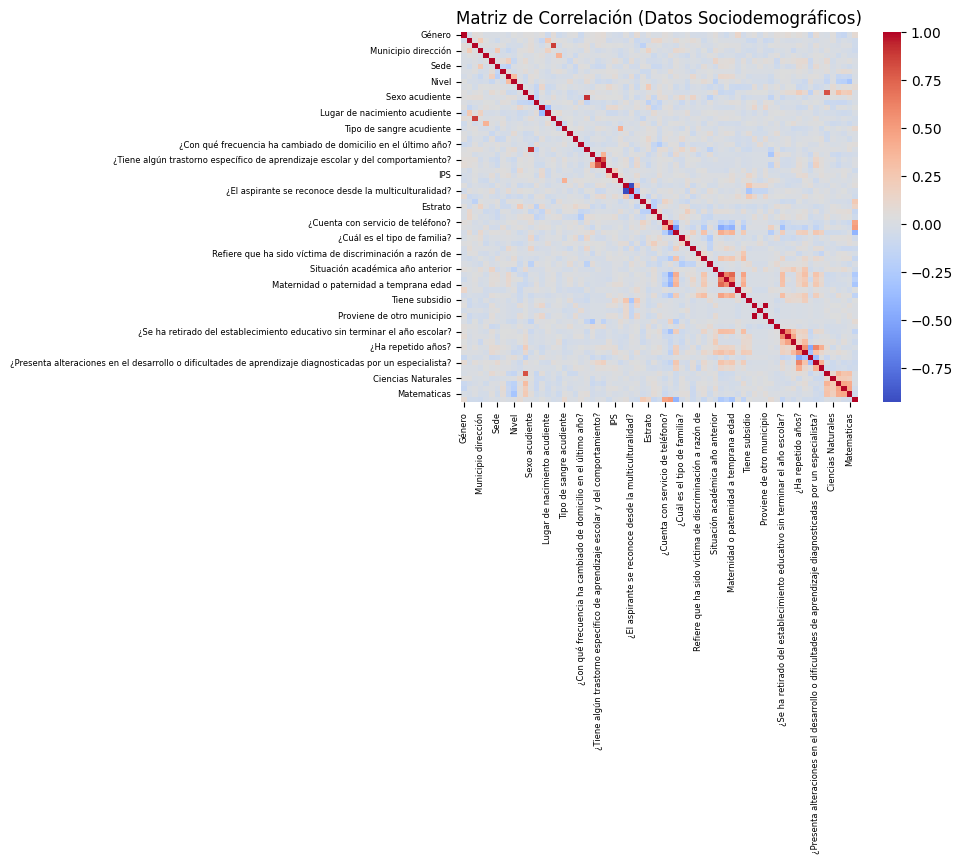

In [ ]:
# Correlación Spearman
corr_fin = df_fin_n.iloc[:,1:].corr(method='kendall')


# Plot Matriz Correlación 

sns.heatmap(corr_fin, cmap='coolwarm')
plt.title('Matriz de Correlación (Datos Sociodemográficos)')

plt.xticks(fontsize=6)
plt.yticks(fontsize=6)

plt.show()

In [ ]:
lista=[]
filas=list(corr_fin.index)
columnas=list(corr_fin.columns)

for i in range(len(corr_fin)):
  for j in range(len(corr_fin)):
    if i!=j:
      valid_corr=abs(corr_fin.iloc[i,j])
      if valid_corr>=0.65:
       lista.append((filas[i],columnas[j],valid_corr))

In [ ]:
# Conteo de valores con alta correlación
val_uniq=[]
for l in range(len(lista)):
  b1=lista[l][0]
  b2=lista[l][1]
  if b1 not in val_uniq:
    val_uniq.append(b1)
  if b2 not in val_uniq:
    val_uniq.append(b2)

dic_uniq={}
for k in val_uniq:
  contador=0
  for l in range(len(lista)):
    b1=lista[l][0] 
    b2=lista[l][1]
    if b1 == k or b2 == k:
     contador += 1
  dic_uniq[k] = contador
dic_uniq

{'Dirección': 2,
 'Dirección acudiente': 2,
 'Edad': 2,
 'Grado': 2,
 'Sexo acudiente': 2,
 'Parentesco del acudiente': 2,
 '¿Tiene algún trastorno específico de aprendizaje escolar y del comportamiento?': 2,
 '¿Tiene acompañamiento del sector salud?': 2,
 '¿El aspirante es población víctima de conflicto?': 2,
 '¿El aspirante se reconoce desde la multiculturalidad?': 2,
 'El estudiante vive solo': 2,
 'Maternidad o paternidad a temprana edad': 2,
 'Beneficiario veterano fuerza pública': 2,
 'Proviene de otro municipio': 2}

In [ ]:
# Correlación múltiple de variables sociodemográficas

# Matriz de covarianzas
S_p3fin = df_fin_n.iloc[:,1:].cov().values

# Matriz Inversa de covarianzas
S_inv_p3fin = np.linalg.inv(S_p3fin)
S_inv_p3fin.round(2)

Vector_Corre_Multiples = 1 - 1/ (np.diag(S_p3fin) * np.diag(S_inv_p3fin))
Vector_Corre_Multiples.round(4)

<ipython-input-1653-e703bd0a0013>:10: RuntimeWarning: divide by zero encountered in true_divide
  Vector_Corre_Multiples = 1 - 1/ (np.diag(S_p3fin) * np.diag(S_inv_p3fin))


array([ 0.9844,  1.0577,  0.9255,  0.9864,  2.7514,  1.029 ,  1.0072,
        1.1023,  0.965 ,  1.0236,  0.6479,  0.9373,  1.0133,  1.0848,
        3.9164,  1.1128,  0.8583,  1.0801,  0.3422,  0.7056,  1.146 ,
        0.8653,  2.3269,  1.0316,  0.9914,  1.015 ,  0.5977,  2.0205,
        1.1261,  0.7323,  1.3625, -1.9585,  0.476 ,  1.1034,  0.3031,
        0.8529,  0.842 ,  1.0495,  0.9629,  0.8918,  0.6719,  0.454 ,
        0.4979,  0.9452,  1.0388,  0.8362,  0.7022,  3.0572,  0.5316,
        1.1999,  0.1761,  0.5841,  1.    , -1.3356,  1.    ,  0.6356,
        1.0344,  0.9489,  1.1571, -0.7403,  2.1458,  1.0623,  0.8583,
        0.4948,  0.7523,  1.0113,  1.0214,  0.9867,  0.5371,  0.9747,
           inf])

In [ ]:
df_fin_model=df_fin_n.copy()
df_fin_model=df_fin_model.drop(columns=['Municipio de nacimiento', 'Dirección', 'Fecha de matrícula', 'Categoría', 'Lugar de nacimiento acudiente', 
                               '¿Con qué frecuencia ha cambiado de domicilio en el último año?','Tipo de sangre','¿El aspirante es población víctima de conflicto?',
                               '¿Cuenta con servicio de teléfono?','¿Cuenta con recolección de basuras?','Beneficiario madre cabeza de familia','El estudiante vive solo',
                               '¿Refiere que ha sido víctima de agresiones físicas, verbales o sexuales por parte de alguien de su entorno educativo o familiar?',
                               'Beneficiario veterano fuerza pública','Antecedentes disciplinarios de la vida académica'])

In [ ]:
Y=df_fin_model.loc[:,['Matematicas','Lenguaje','Competencias Ciudadanas','Ciencias Naturales']]
Y.reset_index(drop=True, inplace=True)
X_mod3=df_fin_model.drop(['id_estudiante'] + list(Y.columns), axis=1)
X_mod3.reset_index(drop=True, inplace=True)

###Target: Vector distancias al resultado ideal

In [ ]:
# Vector distancia de los datos al ideal
# Nota: El resultado ideal se toma como el vector [1, 1, 1, 1], que corresponde a un score perfecto en las 4 materias

y_euclidea_ideal = np.array([distance.euclidean(Y.iloc[d, :], np.array([1,1,1,1])) for d in range(len(Y))])

(array([  2.,  30.,  53.,  73., 102.,  85.,  88.,  37.,  23.,   8.]),
 array([0.2       , 0.37519221, 0.55038443, 0.72557664, 0.90076885,
        1.07596106, 1.25115328, 1.42634549, 1.6015377 , 1.77672992,
        1.95192213]),
 <BarContainer object of 10 artists>)

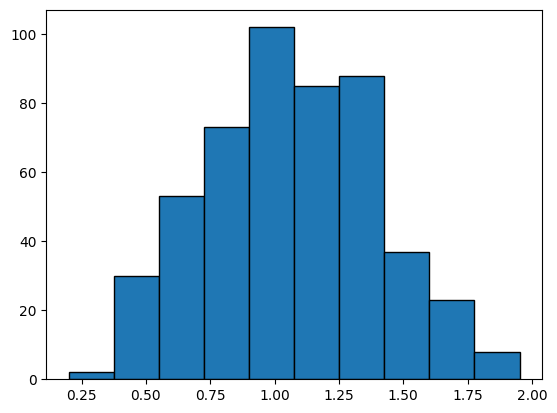

In [ ]:
# Plot de distancias al ideal 

## Nota: entre menor distancia, mejor el resultado!!

plt.hist(y_euclidea_ideal, bins=10, edgecolor='black')

In [ ]:
# Definición de percentiles para indexar 

perc_25 = np.percentile(y_euclidea_ideal, 25)
perc_50 = np.percentile(y_euclidea_ideal, 50)
perc_75 = np.percentile(y_euclidea_ideal, 75)


In [ ]:
# Definición de Corte Académico (Indices)

corte_sup = Y[y_euclidea_ideal <= perc_25].index
corte_medsup = Y[(perc_25 < y_euclidea_ideal) & (y_euclidea_ideal <= perc_50)].index
corte_medinf = Y[(perc_50 < y_euclidea_ideal) & (y_euclidea_ideal <= perc_75)].index
corte_inf = Y[perc_75 < y_euclidea_ideal].index


In [ ]:
# Vista de resultados corte inferior

Y.iloc[corte_inf,:].head(5)

,Matematicas,Lenguaje,Competencias Ciudadanas,Ciencias Naturales
1,0.40,0.60,0.10,0.20
22,0.30,0.40,0.00,0.40
31,0.50,0.30,0.20,0.30
33,0.10,0.30,0.20,0.50
35,0.20,0.10,0.00,0.10


In [ ]:
# Vista de resultados corte superior

Y.iloc[corte_sup,:].head(5)

,Matematicas,Lenguaje,Competencias Ciudadanas,Ciencias Naturales
3,0.50,0.70,0.60,0.80
5,0.50,0.50,0.80,0.80
9,0.70,0.80,0.60,0.40
10,0.60,0.70,0.50,0.60
11,0.50,0.70,0.80,0.70


In [ ]:
# Matriz con vector target (Creación Vector Y = [])

matriz_materias_classified = Y.copy()
matriz_materias_classified['Y'] = ""

In [ ]:
# Poblar vector target

matriz_materias_classified.loc[corte_sup, 'Y'] = 3 # Corte Superior
matriz_materias_classified.loc[corte_medsup, 'Y'] = 2 # Corte Medio-Superior
matriz_materias_classified.loc[corte_medinf, 'Y'] = 1 # Corte Medio-Inferior
matriz_materias_classified.loc[corte_inf, 'Y'] = 0 # Corte Inferior

In [ ]:
# Matriz con vector target dado por distancia al ideal

matriz_materias_classified

,Matematicas,Lenguaje,Competencias Ciudadanas,Ciencias Naturales,Y
0,0.30,0.80,0.40,0.50,1
1,0.40,0.60,0.10,0.20,0
2,0.80,0.70,0.60,0.30,2
3,0.50,0.70,0.60,0.80,3
4,0.60,0.70,0.40,0.50,2
...,...,...,...,...,...
496,0.80,0.70,0.70,1.00,3
497,0.00,0.00,0.20,0.10,0
498,0.50,0.40,0.40,0.40,1
499,0.60,0.40,0.80,0.90,3


In [ ]:
# Vector target de distancias euclidea ideales

Y_dist_ideal = matriz_materias_classified['Y']

In [ ]:
# Correlación múltiple de variables con target ['Y']

# Creación de matriz con atributos y target

matriz_corr_target = X.copy()

matriz_corr_target['clasificacion'] = Y_dist_ideal.astype(int)

# Matriz de covarianzas

S_ = matriz_corr_target.cov().values

# Matriz Inversa de covarianzas
S_inv_ = np.linalg.inv(S_)
S_inv_.round(2)

Vector_Corre_Multiples_target = 1 - 1/ (np.diag(S_) * np.diag(S_inv_))
Vector_Corre_Multiples_target.round(4)

array([0.0519, 0.9298, 0.3249, 0.7543, 0.1244, 0.0952, 0.7509, 0.9914,
       0.0608, 0.0965, 0.8449, 0.9517, 0.6536, 0.8441, 0.9891, 0.6456,
       0.2108, 0.1519, 0.083 , 0.1533, 0.1154, 0.1101, 0.0973, 0.0416])

### Target: K-means


In [ ]:
# Matriz materias

matriz_k_means = Y.copy()

In [ ]:
# Modelo K-means

from sklearn.cluster import KMeans
import numpy as np

km = KMeans (n_clusters=3, random_state=13)
y_predicted = km.fit_predict(matriz_k_means[['Ciencias Naturales', 'Competencias Ciudadanas', 'Lenguaje',
       'Matematicas']])


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
# Creación de columna `cluster` para aislar los resultados

matriz_k_means['Y'] = y_predicted

In [ ]:
# Descripción estadísticas de clustering

print(matriz_k_means[matriz_k_means['Y'] == 0 ].iloc[:,:-1].describe())
print()
print(matriz_k_means[matriz_k_means['Y'] == 1 ].iloc[:,:-1].describe())
print()
print(matriz_k_means[matriz_k_means['Y'] == 2 ].iloc[:,:-1].describe())
print()

### Se percibe que los clusters están distribuidos de la siguiente manera: 
## Cluster 0: Estudiantes de bajo rendimiento
## Cluster 1: Estudiantes de mediano rendimiento
## Cluster 2: Estudiantes de alto rendimiento 


       Matematicas  Lenguaje  Competencias Ciudadanas  Ciencias Naturales
count       155.00    155.00                   155.00              155.00
mean          0.33      0.29                     0.22                0.32
std           0.16      0.17                     0.14                0.18
min           0.00      0.00                     0.00                0.00
25%           0.20      0.20                     0.10                0.20
50%           0.30      0.30                     0.20                0.30
75%           0.40      0.40                     0.30                0.40
max           0.80      0.70                     0.70                0.80

       Matematicas  Lenguaje  Competencias Ciudadanas  Ciencias Naturales
count       194.00    194.00                   194.00              194.00
mean          0.51      0.57                     0.43                0.48
std           0.15      0.15                     0.15                0.19
min           0.10      0.20         

In [ ]:
# Idx de diferentes clusters

idx_0 = matriz_k_means[matriz_k_means['Y'] == 0 ].iloc[:,:-1].index # bajo rendimiento
idx_1 = matriz_k_means[matriz_k_means['Y'] == 1 ].iloc[:,:-1].index # mediano rendimiento
idx_2 = matriz_k_means[matriz_k_means['Y'] == 2 ].iloc[:,:-1].index # alto rendimiento

In [ ]:
# Conteo de estudiantes por cluster

bajo_rend = len(idx_0)
alto_rend = len(idx_1)
med_rend = len(idx_2)

print(f'Estudiantes de bajo rendimiento: {bajo_rend}')
print()
print(f'Estudiantes de alto rendimiento: {med_rend}')
print()
print(f'Estudiantes de mediano rendimiento: {alto_rend}')

Estudiantes de bajo rendimiento: 155

Estudiantes de alto rendimiento: 152

Estudiantes de mediano rendimiento: 194


In [ ]:
# Correlación múltiple de variables con target ['Y']

# Creación de matriz con atributos y target

matriz_corr_kmeans = X_mod3.copy()

matriz_corr_kmeans['Y'] = y_predicted

# Matriz de covarianzas

S_kmeans = matriz_corr_kmeans.cov().values

# Matriz Inversa de covarianzas
S_inv_kmeans = np.linalg.inv(S_kmeans)
S_inv_kmeans.round(2)

Vector_Multiples_kmeans = 1 - 1/ (np.diag(S_kmeans) * np.diag(S_inv_kmeans))
Vector_Multiples_kmeans.round(4)

array([0.1232, 0.3787, 0.3239, 0.4078, 0.1366, 0.2336, 0.3443, 0.8028,
       0.8784, 0.2426, 0.1257, 0.1042, 0.3559, 0.1109, 0.1329, 0.176 ,
       0.8757, 0.512 , 0.8038, 0.8363, 0.1264, 0.1225, 0.2084, 0.2052,
       0.2074, 0.2876, 0.2565, 0.1917, 0.415 , 0.1776, 0.202 , 0.1492,
       0.0935, 0.2176, 0.1798, 0.4115, 0.4741, 0.1207, 0.2318, 0.054 ,
       0.1583, 0.1877, 0.1192, 0.403 , 0.2884, 0.1847, 0.6331, 0.5103,
       0.4928, 0.2728, 0.7971, 0.3478, 0.3145])

## Modelos

### Model Decision Tree Classifier

#### Modelos: Decision Tree Classifier(K-means)


In [ ]:
# Modelo de Classificador Decision Tree Classifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

In [ ]:
# Splitting the data

X_trainset, X_testset, y_trainset, y_testset = train_test_split(X_mod3, matriz_corr_kmeans['Y'].astype(int), test_size=0.3, random_state=3)

tree_class = DecisionTreeClassifier(random_state=3)

tree_class.fit(X_trainset, y_trainset)


DecisionTreeClassifier(random_state=3)

In [ ]:
# Precisión

acc = np.mean(tree_class.predict(X_testset) == y_testset).round(4)

print(f'La precisión del modelo Tree Classifier es de {acc * 100} %')

La precisión del modelo Tree Classifier es de 45.7 %


#### Modelos: Decision Tree Classifier (Distancia Euclidea)

In [ ]:
from sklearn import metrics

print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_testset, tree_class.predict(X_testset)))

DecisionTrees's Accuracy:  0.45695364238410596


In [ ]:
# Splitting the data

X_trainset, X_testset, y_trainset, y_testset = train_test_split(X_mod3, Y_dist_ideal.astype(int), test_size=0.3, random_state=3)

tree_class = DecisionTreeClassifier(random_state=3)

tree_class.fit(X_trainset, y_trainset)


DecisionTreeClassifier(random_state=3)

In [ ]:
# Precisión

acc = np.mean(tree_class.predict(X_testset) == y_testset).round(4)

print(f'La precisión del modelo Tree Classifier es de {acc * 100} %')

La precisión del modelo Tree Classifier es de 33.11 %


In [ ]:
from sklearn import metrics

print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_testset, tree_class.predict(X_testset)))

DecisionTrees's Accuracy:  0.33112582781456956


### Model Random Forest

#### Modelos: Random Forest (K-means)


In [ ]:
# Modelo de Classificador Random Forest

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [ ]:
# Splitting the data

X_trainset, X_testset, y_trainset, y_testset = train_test_split(X_mod3, matriz_corr_kmeans['Y'].astype(int), test_size=0.3, random_state=3)

forest = RandomForestClassifier(criterion='gini', n_estimators=100)

forest.fit(X_trainset, y_trainset)


RandomForestClassifier()

In [ ]:
# Precisión

acc = np.mean(forest.predict(X_testset) == y_testset).round(4)

print(f'La precisión del modelo Random Forest es de {acc * 100} %')

La precisión del modelo Random Forest es de 46.36 %


#### Modelos: Random Forest (Distancia Euclidea)

In [ ]:
# Modelo de Classificador Random Forest

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [ ]:
# Splitting the data

X_trainset, X_testset, y_trainset, y_testset = train_test_split(X_mod3, Y_dist_ideal.astype(int), test_size=0.3, random_state=3)

forest = RandomForestClassifier(criterion='gini', n_estimators=100)

forest.fit(X_trainset, y_trainset)


RandomForestClassifier()

In [ ]:
# Precisión

acc = np.mean(forest.predict(X_testset) == y_testset).round(4)

print(f'La precisión del modelo Random Forest es de {acc * 100} %')

La precisión del modelo Random Forest es de 37.75 %


### Model Support Vector Machine


#### Modelos: SVM (Distancia Euclidea)

In [ ]:
from sklearn.svm import SVC
X_trainset, X_testset, y_trainset, y_testset = train_test_split(X_mod3, Y_dist_ideal.astype(int), test_size=0.3, random_state=3)
clf = SVC(kernel='linear')
clf.fit(X_trainset, y_trainset)
predictions = clf.predict(X_testset)
metrics.accuracy_score(y_testset, tree_class.predict(X_testset))


0.33112582781456956

#### Modelos: SVM (K-means)

In [ ]:
from sklearn.svm import SVC
X_trainset, X_testset, y_trainset, y_testset = train_test_split(X_mod3, matriz_corr_kmeans['Y'].astype(int), test_size=0.3, random_state=3)
clf = SVC(kernel='linear')
clf.fit(X_trainset, y_trainset)
predictions = clf.predict(X_testset)
metrics.accuracy_score(y_testset, tree_class.predict(X_testset))


0.2913907284768212

#Método 4: Método de votación

In [ ]:
#Variables que se tienen en cuenta en cada método
col_mod1=X_mod1.columns
col_mod2=X_mod2.columns
col_mod3=X_mod3.columns

In [ ]:
#Conteo de variables por métodos
columnas=estudiantes.columns
dicc_col={}
for c in columnas:
  contador=0
  if c in col_mod1:
   contador += 1
  if c in col_mod2:
   contador += 1
  if c in col_mod3:
    contador += 1
  
  if contador > 0:
    dicc_col[c]=contador


In [ ]:
tabla_conteo=pd.DataFrame({'Variables':list(dicc_col.keys()),'Conteo':list(dicc_col.values())})
tabla_conteo

,Variables,Conteo
0,Género,3
1,Municipio dirección,2
2,Barrio dirección,1
3,Sede,3
4,Formalizada,1
...,...,...
62,Abandonos temporales (año lectivo actual),1
63,¿Ha repetido años?,1
64,¿Está repitiendo el grado actual?,1
65,¿Presenta alteraciones en el desarrollo o difi...,1


In [ ]:
#Escoger las variables que coincidieron en los tres modelos
tabla_esc=tabla_conteo[tabla_conteo['Conteo'] == 3]

In [ ]:
df_mod4=df_merged_p3[tabla_esc['Variables'].to_list() + ['Matematicas'] + ['Ciencias Naturales'] + ['Competencias Ciudadanas'] + ['Lenguaje']].dropna(axis=0)
X_mod4=df_mod4.iloc[:,0:6]
Y_mat=df_mod4.iloc[:,6:10]

### Encoding

In [ ]:

# Conversión de variables de acudientes a variables numéricas
# Selección de variables

columnas_encp4=X_mod4.iloc[:,list(range(0,3))+[4]]

# Categorizador
categorizador = preprocessing.LabelEncoder()

for c in columnas_encp4:
  categorizador.fit(X_mod4[c])
  X_mod4[c] = categorizador.transform(X_mod4[c]) 

In [ ]:
X_mod4['Estrato']=X_mod4['Estrato'].astype(int)
X_mod4['¿Con cuántas personas vive?'] = X_mod4['¿Con cuántas personas vive?'].replace('Más de 10', 10)
X_mod4['¿Con cuántas personas vive?'] = X_mod4['¿Con cuántas personas vive?'].astype(int)


###Target: Vector diastancias al resultado ideal

In [ ]:
# Vector distancia de los datos al ideal
# Nota: El resultado ideal se toma como el vector [1, 1, 1, 1], que corresponde a un score perfecto en las 4 materias

y_euclidea_ideal = np.array([distance.euclidean(Y_mat.iloc[d, :], np.array([1,1,1,1])) for d in range(len(Y_mat))])

In [ ]:
# Definición de percentiles para indexar 

perc_25 = np.percentile(y_euclidea_ideal, 25)
perc_50 = np.percentile(y_euclidea_ideal, 50)
perc_75 = np.percentile(y_euclidea_ideal, 75)


In [ ]:
# Definición de Corte Académico (Indices)

corte_sup = Y_mat[y_euclidea_ideal <= perc_25].index
corte_medsup = Y_mat[(perc_25 < y_euclidea_ideal) & (y_euclidea_ideal <= perc_50)].index
corte_medinf = Y_mat[(perc_50 < y_euclidea_ideal) & (y_euclidea_ideal <= perc_75)].index
corte_inf = Y_mat[perc_75 < y_euclidea_ideal].index


In [ ]:
# Matriz con vector target (Creación Vector Y = [])

matriz_materias_classified = Y_mat.copy()
matriz_materias_classified['Y'] = ""

In [ ]:
# Poblar vector target

matriz_materias_classified.loc[corte_sup, 'Y'] = 3 # Corte Superior
matriz_materias_classified.loc[corte_medsup, 'Y'] = 2 # Corte Medio-Superior
matriz_materias_classified.loc[corte_medinf, 'Y'] = 1 # Corte Medio-Inferior
matriz_materias_classified.loc[corte_inf, 'Y'] = 0 # Corte Inferior

In [ ]:
# Vector target de distancias euclidea ideales

Y_dist_ideal = matriz_materias_classified['Y']

### Target: K-means

In [ ]:
# Matriz materias

matriz_k_means = Y_mat.copy()

In [ ]:
# Modelo K-means

from sklearn.cluster import KMeans
import numpy as np

km = KMeans (n_clusters=3, random_state=13)
y_predicted = km.fit_predict(matriz_k_means[['Ciencias Naturales', 'Competencias Ciudadanas', 'Lenguaje',
       'Matematicas']])


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


### Modelos

### Model Decision Tree Classifier

#### Modelos: Decision Tree Classifier(K-means)


In [ ]:
# Modelo de Classificador Decision Tree Classifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

In [ ]:
# Splitting the data

X_trainset, X_testset, y_trainset, y_testset = train_test_split(X_mod4,y_predicted.astype(int), test_size=0.3, random_state=3)

tree_class = DecisionTreeClassifier(random_state=3)

tree_class.fit(X_trainset, y_trainset)


DecisionTreeClassifier(random_state=3)

In [ ]:
# Precisión

acc = np.mean(tree_class.predict(X_testset) == y_testset).round(4)

print(f'La precisión del modelo Tree Classifier es de {acc * 100} %')

La precisión del modelo Tree Classifier es de 37.16 %


#### Modelos: Decision Tree Classifier (Distancia Euclidea)

In [ ]:
# Splitting the data

X_trainset, X_testset, y_trainset, y_testset = train_test_split(X_mod4, Y_dist_ideal.astype(int), test_size=0.3, random_state=3)

tree_class = DecisionTreeClassifier(random_state=3)

tree_class.fit(X_trainset, y_trainset)


DecisionTreeClassifier(random_state=3)

In [ ]:
# Precisión

acc = np.mean(tree_class.predict(X_testset) == y_testset).round(4)

print(f'La precisión del modelo Tree Classifier es de {acc * 100} %')

La precisión del modelo Tree Classifier es de 22.400000000000002 %


In [ ]:
# Modelo de Classificador Decision Tree Classifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

In [ ]:
# Splitting the data

X_trainset, X_testset, y_trainset, y_testset = train_test_split(X_mod3, matriz_corr_kmeans['Y'].astype(int), test_size=0.3, random_state=3)

tree_class = DecisionTreeClassifier(random_state=3)

tree_class.fit(X_trainset, y_trainset)


DecisionTreeClassifier(random_state=3)

In [ ]:
# Precisión

acc = np.mean(tree_class.predict(X_testset) == y_testset).round(4)

print(f'La precisión del modelo Tree Classifier es de {acc * 100} %')

La precisión del modelo Tree Classifier es de 45.7 %


In [ ]:
# Splitting the data

X_trainset, X_testset, y_trainset, y_testset = train_test_split(X_mod4, Y_dist_ideal.astype(int), test_size=0.3, random_state=3)

tree_class = DecisionTreeClassifier(random_state=3)

tree_class.fit(X_trainset, y_trainset)


DecisionTreeClassifier(random_state=3)

In [ ]:
# Precisión

acc = np.mean(tree_class.predict(X_testset) == y_testset).round(4)

print(f'La precisión del modelo Tree Classifier es de {acc * 100} %')

La precisión del modelo Tree Classifier es de 22.400000000000002 %


### Model Random Forest

#### Modelos: Random Forest (K-means)


In [ ]:
# Modelo de Classificador Random Forest

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [ ]:
# Splitting the data


X_trainset, X_testset, y_trainset, y_testset = train_test_split(X_mod4,y_predicted.astype(int), test_size=0.3, random_state=3)

forest = RandomForestClassifier(criterion='gini', n_estimators=100)

forest.fit(X_trainset, y_trainset)


RandomForestClassifier()

In [ ]:
# Precisión

acc = np.mean(forest.predict(X_testset) == y_testset).round(4)

print(f'La precisión del modelo Random Forest es de {acc * 100} %')

La precisión del modelo Random Forest es de 38.800000000000004 %


#### Modelos: Random Forest (Distancia Euclidea)

In [ ]:
# Modelo de Classificador Random Forest

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [ ]:
# Splitting the data

X_trainset, X_testset, y_trainset, y_testset = train_test_split(X_mod4, Y_dist_ideal.astype(int), test_size=0.3, random_state=3)

forest = RandomForestClassifier(criterion='gini', n_estimators=100)

forest.fit(X_trainset, y_trainset)


RandomForestClassifier()

In [ ]:
# Precisión

acc = np.mean(forest.predict(X_testset) == y_testset).round(4)

print(f'La precisión del modelo Random Forest es de {acc * 100} %')

La precisión del modelo Random Forest es de 26.779999999999998 %


### Model Support Vector Machine


#### Modelos: SVM (Distancia Euclidea)

In [ ]:
from sklearn.svm import SVC
X_trainset, X_testset, y_trainset, y_testset = train_test_split(X_mod4, Y_dist_ideal.astype(int), test_size=0.3, random_state=3)
clf = SVC(kernel='linear')
clf.fit(X_trainset, y_trainset)
predictions = clf.predict(X_testset)


In [ ]:
# Precisión

acc = metrics.accuracy_score(y_testset, tree_class.predict(X_testset))

print(f'La precisión del modelo Random Forest es de {acc * 100} %')

La precisión del modelo Random Forest es de 22.404371584699454 %


#### Modelos: SVM (K-means)

In [ ]:
from sklearn.svm import SVC
X_trainset, X_testset, y_trainset, y_testset = train_test_split(X_mod4,y_predicted.astype(int), test_size=0.3, random_state=3)
clf = SVC(kernel='linear')
clf.fit(X_trainset, y_trainset)
predictions = clf.predict(X_testset)



In [ ]:
#Precisión
acc=metrics.accuracy_score(y_testset, tree_class.predict(X_testset))
print(f'La precisión del modelo Tree Classifier es de {acc * 100} %')

La precisión del modelo Tree Classifier es de 25.683060109289617 %
